# XSOR Project - task 2: Trending asset into mean reverting asset

Trending assets are those whose prices or returns display a sustained movement in one direction (upward or
downward) over time. Trending assets are typically non-stationary, meaning their statistical properties (e.g.,
mean, variance) evolve over time. This poses challenges for many standard financial analyses, which assume
stationarity.

In this part of the project, instead of analyzing an already mean-reverting asset, our task was to transform a
trending financial asset into one that exhibits mean-reverting behavior through mathematical or statistical normalization
techniques.

## Graphical introduction: heikin ashi candlestick plot

**OHLC Data** (Open, High, Low, Close) is a format in financial data analysis that captures key price points of an
asset for a given timeframe (e.g., minute, hour, day). Similar to a bar chart, an OHLC candlestick chart displays
the market’s opening, highest, lowest, and last prices for a given timeframe. The candlestick comprises a broader
section known as the ”real body.”

This real body signifies the price range between the opening and closing prices.  
If the real body is filled or colored <span style="color:red;"><b>red</b></span>, it signifies that the closing price was lower than the opening price.  
Conversely, when the real body is <span style="color:green;"><b>green</b></span>, it indicates that the closing price exceeded the opening price.

<p align="center">
  <img src="Fig/image.png" alt="Figure" width="600px" />
</p>

**Heiken- Ashi**: A useful way to visualize trends is by mean of Heiken-Ashi candlesticks. Heiken Ashi (HA) is
a modified candlestick charting technique used in technical analysis to smooth out price action and highlight
trends more clearly. It modifies the traditional Open, High, Low, Close (OHLC) data with a specific formula,
creating a visual representation that filters out some market noise.
The Heiken Ashi (HA) values are calculated as follows:

#### HA Close:
$$
HA\_Close_t = \frac{Open_t + High_t + Low_t + Close_t}{4}
$$

#### HA Open:
$$
HA\_Open_t = \frac{HA\_Open_{t-1} + HA\_Close_{t-1}}{2}
$$
For the first period, the standard \( Open_t \) is used as the starting value.

#### HA High:
$$
HA\_High_t = \max(High_t, HA\_Open_t, HA\_Close_t)
$$

#### HA Low:
$$
HA\_Low_t = \min(Low_t, HA\_Open_t, HA\_Close_t)
$$

HA candles are useful for identifying trends and reversal signals. At a high level, they can be interpreted as follows:

- **Bullish Trends:** Candles with large bodies and no lower wicks typically indicate strong upward trends.
- **Bearish Trends:** Candles with large bodies and no upper wicks typically indicate strong downward trends.
- **Reversal Signals:** Small bodies with both upper and lower wicks may indicate a potential reversal or consolidation.


Here is an example graph:

![An example of trending asset](Fig/trades2.png "An example of trending asset")

However, for the future analysis, we will focus only on Closing Prices, as they are less aftected by daily fluctuactions

## Part 1: A metric for mean reversion

### What is mean reversion ?

![An example of trending asset](Fig/closing_prices_plot.png "An example of trending asset") **Figure 3:** An example of a trending asset

A **Trending asset** is an asset whose prices or returns tend to move back toward their historical average or mean over time.

A typical example is the Ornstein-Uhlenbeck process, which models mean-reverting behavior. The equation for the O-U process is:

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t
$$

The solution to this SDE is given by:

$$
X_t = X_0 e^{-\theta t} + \mu \left( 1 - e^{-\theta t} \right) + \sigma \int_0^t e^{-\theta(t-s)} dW_s
$$


Where:
- $ X_t $ is the asset price (or return) at time $ t $,
- $ \mu $ is the long-term mean of the process,
- $ \theta $ is the rate at which the process reverts to the mean (also called the speed of mean reversion),
- $ \sigma $ is the volatility of the process,
- $ dW_t $ is a Wiener process or Brownian motion term representing random noise.


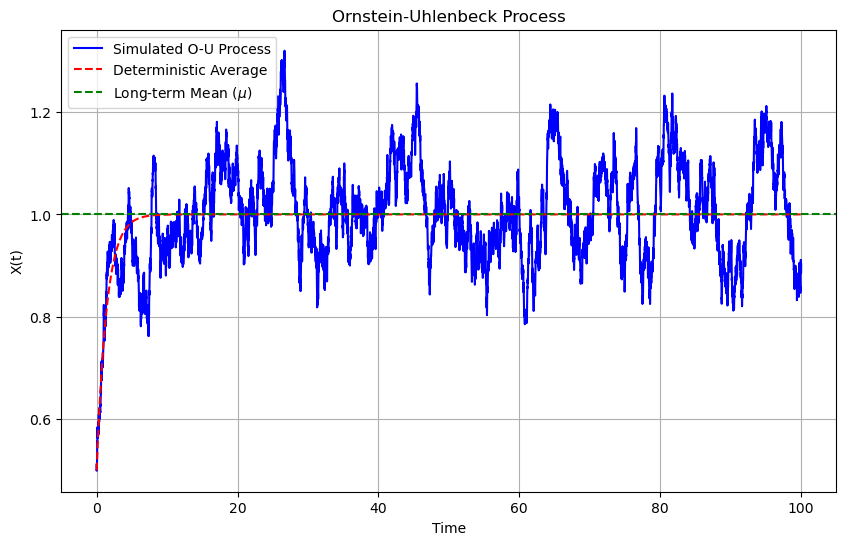

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *


# Parameters for the Ornstein-Uhlenbeck process
theta = 0.7     # rate of mean reversion
mu = 1.0        # long-term mean
sigma = 0.1     # volatility
X0 = 0.5        # initial value
T = 100          # total time
dt = 0.01       # time step
n_steps = int(T / dt)  # number of steps

# Time array
time = np.linspace(0, T, n_steps)

# Initialize the array to store the process values
X = np.zeros(n_steps)
X[0] = X0

# Simulate the Ornstein-Uhlenbeck process
for t in range(1, n_steps):
    dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
    X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW

# Analytical solution for comparison
X_analytical = X0 * np.exp(-theta * time) + mu * (1 - np.exp(-theta * time))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, X, label="Simulated O-U Process", color="blue")
plt.plot(time, X_analytical, label="Deterministic Average", color="red", linestyle='dashed')
plt.axhline(mu, color="green", linestyle="--", label="Long-term Mean ($\mu$)")
plt.title("Ornstein-Uhlenbeck Process")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

# Overview

### Preprocess
Before diving into our analysis, we will preprocess our dataset to ensure data quality and consistency.  

### Focus Areas  
- **Group 1's Task:** Develop a metric for **mean reversion**.  
- **Our Task:** Instead of focusing on mean reversion, we will implement **predefined tests** to determine whether our dataset exhibits a trend within a given time window.  

### Approach  
1. **Trend Detection:** Apply statistical tests to classify intervals as trending or non-trending.  
2. **Detrending Methods:**  
   - Implement a **statistical approach** based on test results.  
   - Compare it to a more **empirical method** that does not rely on formal statistical tests.  
3. Use **Group 1's mean reversion metric** to assess and validate the effectiveness of our detrending methods

# Preprocess

### Fitlering the signal

Before applying each test, we first **filter the signal**.  

To achieve this, we implemented a function that removes a fraction of high-frequency components. This is done by discarding a selected portion of the **Area Under the Curve (AUC)** of the power spectrum. In our case, we discard **1% (0.01) of the total power**.  

---

### Python Implementation  

```python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

def filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.1, plot_spectrum=False):
    """
    Filters the input signal by removing high-frequency components based on the area under the curve (AUC).

    Parameters:
    sig (array-like): The signal to be filtered.
    datetime_index (pd.DatetimeIndex): The datetime index for the signal.
    time_step (float): The time step (in seconds) between each data point (default is 15 minutes).
    discard_fraction (float): Fraction of the total power to discard (default is 10%).

    Returns:
    filtered_sig_series (pd.Series): A Pandas Series containing the filtered signal with the datetime index.
    """
    # Compute the corresponding frequencies
    sample_freq = fftfreq(sig.size, d=time_step)
    pos_mask = sample_freq > 0
    freqs = sample_freq[pos_mask]

    # Perform the FFT
    sig_fft = fft(np.array(sig))
    power = np.abs(sig_fft) ** 2

    # Compute cumulative power
    cumulative_power = np.cumsum(power[pos_mask])
    total_power = cumulative_power[-1]
    target_power = (1 - discard_fraction) * total_power

    # Determine the cutoff frequency
    cutoff_idx = np.searchsorted(cumulative_power, target_power)
    cutoff_freq = freqs[cutoff_idx]

    # Apply the frequency filter
    filtered_fft = sig_fft.copy()
    filtered_fft[np.abs(sample_freq) > cutoff_freq] = 0
    filtered_sig = ifft(filtered_fft)

    # Convert filtered signal to real values (IFFT output might be complex)
    filtered_sig = np.real(filtered_sig)

    # Create a Pandas Series with the datetime index and the filtered signal
    filtered_sig_series = pd.Series(filtered_sig, index=datetime_index)

    if plot_spectrum:
        # Plot for visualization
        plt.figure(figsize=(6, 5))
        plt.plot(freqs, np.cumsum(power[pos_mask]) / total_power, label="Cumulative Power")
        plt.axvline(cutoff_freq, color='red', linestyle='--', label=f"Cutoff: {cutoff_freq:.2e} Hz")
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Normalized Cumulative Power')
        plt.title("Cumulative Power Spectrum")
        plt.legend()
        plt.show()

    return filtered_sig_series
  ```

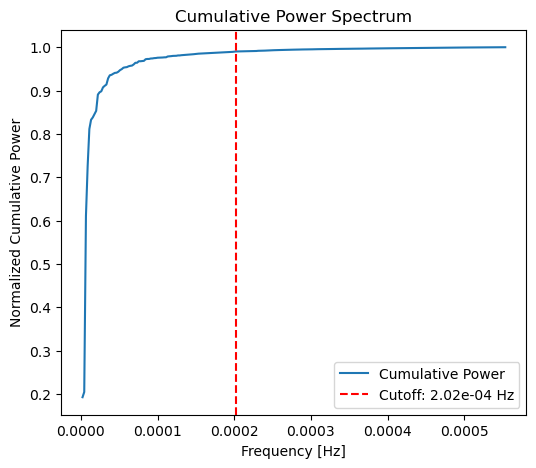

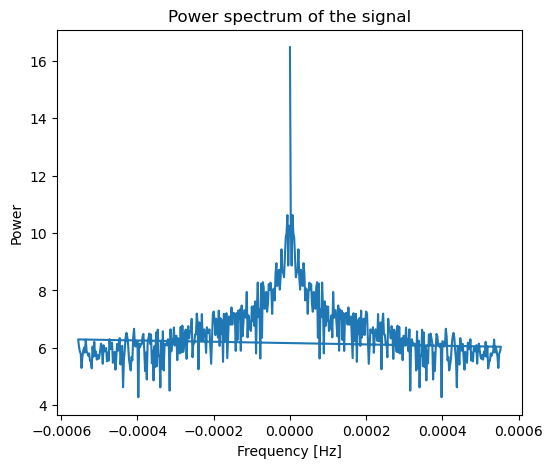

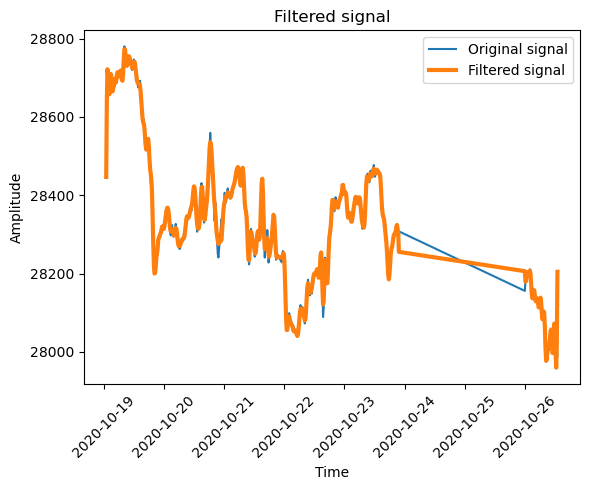

In [197]:
#Import and clean data
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from hurst import compute_Hc

# Example usage:
# Load the data
df, close_data = import_data("data_M15/DJ_M15_202009240845_202411131015.csv") 

# Select the data range for analysis
t_min = 1500
t_max = 2000

# Extract the signal and its datetime index
sig = close_data[t_min:t_max]
datetime_index = close_data.index[t_min:t_max]

# Call the filter_signal function from functions module
#filtered_sig_series = functions.filter_signal(sig, datetime_index, time_step=15*60, freq_factor=10)
filtered_sig_series=filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=True)
filter_signal(sig, datetime_index,plot=True)

# Plot the original and filtered signal
plt.figure(figsize=(6, 5))
plt.plot(datetime_index, sig, label='Original signal')
plt.plot(datetime_index, filtered_sig_series, linewidth=3, label='Filtered signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.title("Filtered signal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical tests

The removal of the trend from the data is performed by applying an algorithm to them. <br>
In this project we were asked for an empirical implementation of such an algorithm. In fact, there are countless examples in the literature that show the difficulties and precautions needed in modeling this type of data (e.g. https://doi.org/10.2307/1183489), and therefore in using rigorous approaches.<br>
By not being rigorous, the algorithm we will build will alter, at least partially, the information contained in the data. Therefore, to minimize this modification, the processing is applied only to the regions where there appears to be a trend. These regions must therefore be identified.<br>
To this end, one of the metrics developed by group 1 could be used, but they depend on the efficiency with which the data are detrended. Predefined tests are then used, since this is a preliminary procedure that will then be strengthened by the feedback mechanism granted by applying the metric of group 1, at the end of the work, to the detrended data.

#### **Hurst exponent**

The **Hurst exponent**, denoted as $ H $, is a statistical measure used to evaluate the long-term memory of time series data. It helps in understanding the behavior of financial time series, indicating whether they are mean-reverting, trending, or following a random walk.

#### Mathematical Background

The Hurst exponent is defined mathematically in terms of the rescaled range $ R(n) $ and standard deviation $ S(n) $ of the time series:

$$
\mathbb{E}\left[\frac{R(n)}{S(n)}\right] = C n^H \quad \text{as } n \to \infty
$$


Where:
- $ R(n) $: The range of the first $ n $ cumulative deviations from the mean.
- $ S(n) $: The standard deviation of the first $ n $ observations.
- $ C $: A constant.


#### Interpretation of Hurst Exponent Values

The value of the Hurst exponent ranges from 0 to 1 and can be interpreted as follows:

- *$$ H < 0.5 $$* Indicates **mean-reverting behavior**. This suggests that the time series tends to revert back to its average over time. For example, a stock price that oscillates around its mean without sustaining a prolonged trend would exhibit this behavior.
  
- *$$ H = 0.5 $$* Suggests that the time series behaves like a **Geometric Brownian Motion**, implying no clear trend and resembling a random walk.

- *$$ H > 0.5 $$* Indicates **trending behavior**. In this case, high values are likely to be followed by more high values, suggesting persistence in the direction of movement.

## Optional: an algorithm base on the autocorrelation function

## A first approach: detrending using Hurst Exponent

We tried to apply this metric in two ways:

1. determine the intervals where data seem to be trending (discussed later)

2. find an "optimal" interval to perform rolling means (a possible strategy to remove trends from the data is to perform rolling means using a certain window with, and then subtracting those values to the actual data).

Let's analyse this approaches:

2. The idea is that there will be an optimal frequency (and corresponding timewindow) which better describes the trend.

Detrending via rolling mean using this window would then provide a minima in the Hurst exponent.


We then tried to compute a "rolling version" of H over a range of windows.

##### Application to the filtered signal

In [198]:
filtered_sig=filtered_sig_series
H_rollv=[]
H_v=[]
x=np.linspace(2,300)
for window in x:
    filtered_new=(filtered_sig-filtered_sig.rolling(window=int(window)).mean()) #Rolling mean over window
    filtered_sig_no_nan = filtered_new[~np.isnan(filtered_new)] #Remove NaN values
    H_roll, c, data=compute_Hc(filtered_sig_no_nan,kind='random_walk', simplified=False) #Compute Hurst exponent
    H, c, data = compute_Hc(filtered_sig,kind='random_walk', simplified=False)
    H_rollv.append(H_roll)

Minimum for x = 8.081632653061224 
H_min = 0.3714390995286591


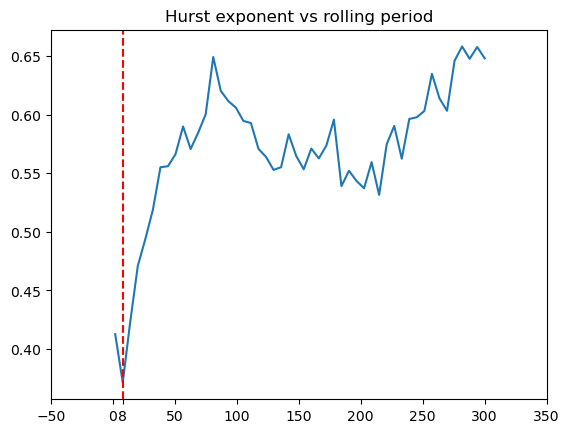

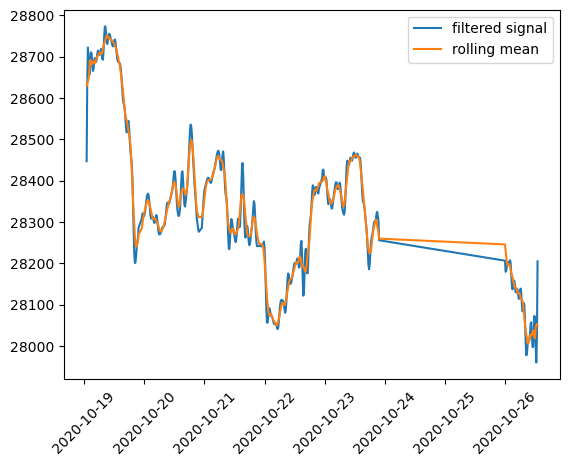

In [199]:
# Plot the Hurst exponent vs rolling period
plt.plot(x, H_rollv)
plt.title("Hurst exponent vs rolling period")

# Find the x-value and y-value corresponding to the minimum of H_rollv
xmin = x[np.argmin(H_rollv)]
Hmin = H_rollv[np.argmin(H_rollv)]

# Print the minimum point
print("Minimum for x =", xmin, "\nH_min =", Hmin)

# Plot a red vertical line at x = xmin
plt.axvline(x=xmin, color='red', linestyle='--')

# Get the current x-ticks
current_ticks = plt.gca().get_xticks()

# Add xmin to the current ticks
new_ticks = np.append(current_ticks, xmin)

# Set the new x-ticks (including the previous ones and xmin)
plt.xticks(new_ticks)

# Display the plot
plt.show()


plt.plot(filtered_sig, label="filtered signal")
plt.plot(filtered_sig.rolling(window=int(xmin), min_periods=1, center=True).mean(), label="rolling mean")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Unfortunately the idea is not very effective, since the Hurst Exponent is higly sensible on the small oscillation of the data of the data, as we will see next.

## 1. determine the intervals where data seem to be trending

We found out that the Hurst exponent can't be considered as a reliable measure of mean revertness. In fact it measures long term behaviors of the time series, but these don't necessary concide with mean-revertness.

An example is provided below, where various sinosoidal timeseries have been generated and trend/ noise has been added to some of them.
Finally the relative Hurst exponents have been computed over a timewindow of N=5000 timesteps, but we can see that there is almost no difference in H before and after detrending.

This may be due, as before, by H focusing on the noise rather than the general trend.

We must also consider that we need enough data points to reliably estimate the Hurst exponent. In fact Hurst’s analysis strongly depend on the length of the time series ([Coronado Jiménez and Carpena, 2005](https://doi.org/10.1007/s10867-005-3126-8)).


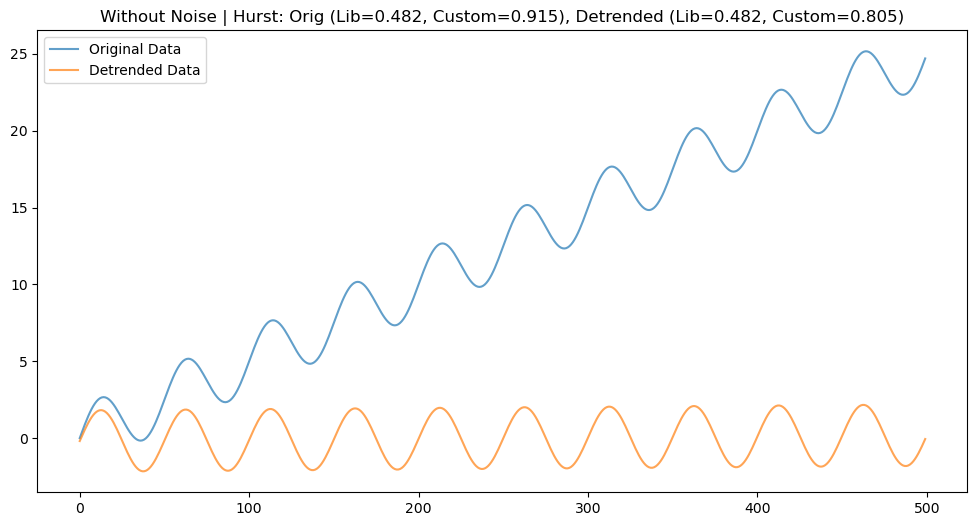

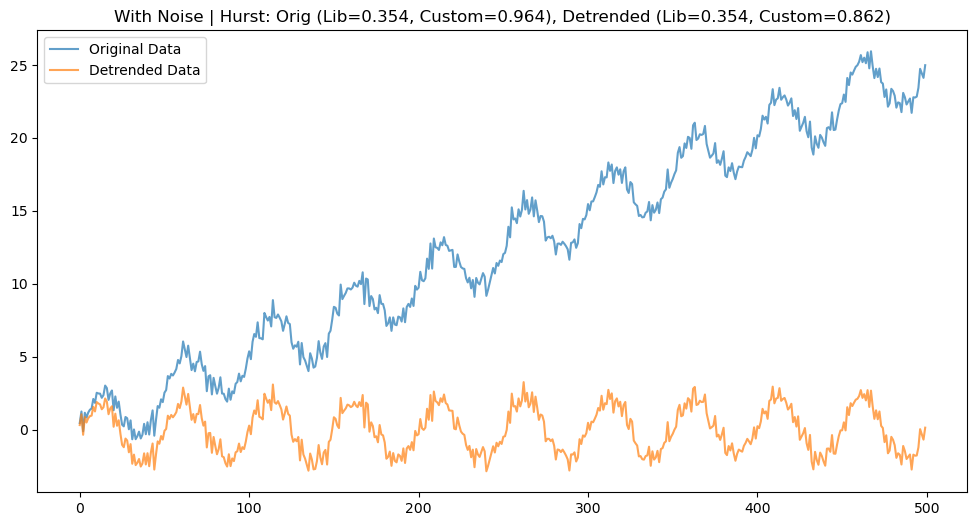

In [200]:
#Trial for final explaination

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hurst import compute_Hc

def hurst_exponent(time_series, min_window=10, max_window=100):
    """
    Estimate the Hurst exponent of a time series using Rescaled Range (R/S) analysis.

    Parameters:
    - time_series: array-like, the time series to analyze.
    - min_window: int, minimum segment size (m).
    - max_window: int, maximum segment size (m).

    Returns:
    - H: float, the estimated Hurst exponent.
    """
    N = len(time_series)
    rs_values = []
    window_sizes = []

    for window_size in range(min_window, min(max_window, N // 2)):
        window_sizes.append(window_size)
        num_windows = N // window_size
        rs_for_window = []

        for i in range(num_windows):
            # Extract the window
            segment = time_series[i * window_size:(i + 1) * window_size]

            # Calculate mean and cumulative deviation
            mean = np.mean(segment)
            cumulative_deviation = np.cumsum(segment - mean)

            # Calculate range (R) and standard deviation (S)
            R = np.max(cumulative_deviation) - np.min(cumulative_deviation)
            S = np.std(segment)

            if S > 0:
                rs_for_window.append(R / S)

        # Average R/S across all windows
        if rs_for_window:
            rs_values.append(np.mean(rs_for_window))

    # Fit a line to log-log plot to estimate H
    log_window_sizes = np.log(window_sizes)
    log_rs_values = np.log(rs_values)
    H, _ = np.polyfit(log_window_sizes, log_rs_values, 1)

    return H

def generate_series(n, trend_slope=0.1, oscillation_amplitude=1.0, noise_level=0.0):
    t = np.arange(n)
    trend = trend_slope * t
    oscillation = oscillation_amplitude * np.sin(2 * np.pi * t / 50)
    noise = np.random.normal(scale=noise_level, size=n)
    return trend + oscillation + noise

def linear_detrend(series):
    t = np.arange(len(series))
    slope, intercept, _, _, _ = linregress(t, series)
    return series - (slope * t + intercept)

def analyze_series(data, title_prefix):
    hurst_lib, _, _ = compute_Hc(data, kind='random_walk', simplified=False)
    hurst_custom = hurst_exponent(data)
    detrended_data = linear_detrend(data)
    hurst_lib_detrended, _, _ = compute_Hc(detrended_data, kind='random_walk', simplified=False)
    hurst_custom_detrended = hurst_exponent(detrended_data)

    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} | Hurst: Orig (Lib={hurst_lib:.3f}, Custom={hurst_custom:.3f}), "
              f"Detrended (Lib={hurst_lib_detrended:.3f}, Custom={hurst_custom_detrended:.3f})")
    plt.show()

np.random.seed(42)
N=500 #length of time series
data_clean = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.0)
analyze_series(data_clean, "Without Noise")
data_noisy = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.5)
analyze_series(data_noisy, "With Noise")

### Alternative approach ###


## Mann-Kendall test

The M-K test is a non parametric test to assess monotonic trends.
It is a hypothesis test:


*   H<sub>0</sub>: There is no monotonic trend in the data. The observations x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub> are independent and randomly ordered over time.
*   H<sub>a</sub>:There is a monotonic trend in the data.

The test computes the difference between each pair of data points and counts how many of these differences are positive or negative, so it evaluates if there are more increasing or decreasing values in the data. When applied to a timeseries the statistic of the test is defined as:

$$
S = \sum_{i=1}^{n-1} \sum_{j=i+1}^{n} \text{sgn} (x_j - x_i)
$$
<br>
where:

$$
\text{sgn} (x_j - x_i) =
\begin{cases}
+1 & \text{if } (x_j - x_i) > 0 \\
0 & \text{if }(x_j - x_i) = 0 \\
-1 & \text{if }(x_j - x_i) < 0
\end{cases}
$$

<br>
and n is the sample size.
To evaluate the significance of 𝑆, the 𝑍 statistic is computed since for $n \geq 10$, S can be approximated by a normal distribution, allowing the use of a z-score:
<br>

$$
Z =
\begin{cases}
\frac{(S - 1)}{\sigma_s} & \text{if } S > 0 \\
0 & \text{if } S = 0 \\
\frac{(S + 1)}{\sigma_s} & \text{if } S < 0
\end{cases}
$$
<br>
where:

$$
\sigma_s = \sqrt{\frac{n(n-1)(2n+5) - \sum_{j=1}^{q} t_j (t_j - 1)(2t_j + 5)}{18}}
$$
<BR>
in which the first term of the difference is the variance of 𝑆 assuming no ties, while the sum accounts for ties, reducing the variance, since tied observations contribute less to a trend; *q* is the number of values that have ties, t<sub>j</sub> how many times the j-th value is repeated.<br>

If Z<Z<sub>α/2</sub> with a significance level α, then there doesn’t exist trend in the timeseries. (https://doi.org/10.2307/1907187, doi:10.1017/S0020268100013019)

However, as H<sub>0</sub> states, the test is sensitive to autocorrelation, so Hamed and Rao developed a new version of the test to account for autocorrelation. According to the idea that when the data are autocorrelated the variance is underestimated, they substitute *n* with an effective length, thus inflating the variance of the test statistic 𝑆 (https://doi.org/10.1016/S0022-1694(97)00125-X). However, when a trend is present, a powerful estimation of the autocorrelation fails, so Yue and Wang developed another version of the test: if the autocorrelation is estiamted from the detrended series, the effective sample size can still effectively reduce the influence of serial correlation on the MK test (https://doi.org/10.1023/B:WARM.0000043140.61082.60).
<br>All these versions (and many more) are implemented in the 'pyMannKendall' python package (https://doi.org/10.21105/joss.01556).<br><br>
Let's try this test and see if its results seem reasonable.

In [201]:
from functions import interval_selector
start_index, end_index = interval_selector(0,20,df)
original_test, modified_test = mann_kendall(chunk_size=192, start_index=start_index, end_index=end_index, df=df)

2020-09-24 08:45:00
0
2020-10-23 15:00:00


![An example of trending asset](Fig/mk.jpeg)

The 'mann_kendall' function is defined as follows:

In [202]:
def mann_kendall(chunk_size, start_index, end_index, df, plotting=False):
    """
    function to apply the mann kendall test to a given window
    """
    original_test=[]
    modified_test=[]
    for i in range(0,int((end_index-start_index)/chunk_size)):

        s=start_index+i*chunk_size
        e=start_index+(i+1)*chunk_size

        prices_filtered=filter_signal_by_auc(df['HA_close'][s:e].values, df[s:e].index,plot_spectrum=False)

        trend_test_modified_filtered = yue_wang_modification_test(prices_filtered)
        trend_test_filtered = original_test(df['HA_close'][s:e].values)

        if (trend_test_filtered[0]=='no trend'):
            original_test.append(0)
        elif (trend_test_filtered[0]=='increasing'):
            original_test.append(1)
        else:
            original_test.append(-1)

        if (trend_test_modified_filtered[0]=='no trend'):
            modified_test.append(0)
        elif (trend_test_modified_filtered[0]=='increasing'):
            modified_test.append(1)
        else:
            modified_test.append(-1)

    if(plotting==True):
        df_filtered= filter_signal_by_auc(df['HA_close'][start_index:end_index].values, df[start_index:end_index].index)
        plt.figure(figsize=(14, 5))
        for i in range(0,len(original_test)):
            s = start_index + i * chunk_size
            e = s + chunk_size

            if(e+3>=len(df_filtered)):
                break

            # Determine the color based on test_result
            if original_test[i] == 1:
                color = 'green'
            elif original_test[i] == -1:
                color = 'red'
            else:
                color = 'blue'

            if modified_test[i] == 1:
                color_filtered = 'orange'
            elif modified_test[i] == -1:
                color_filtered = 'black'
            else:
                color_filtered = 'cyan'

            # Plot the chunk
            plt.plot(df.loc[df.index[s]:df.index[e],['HA_close']], color=color, label='' )
            plt.plot(df_filtered[s-start_index:e-end_index].index, df_filtered[s-start_index:e-end_index].values,color=color_filtered, linewidth=1 )
            plt.axvline(df.index[s], color='grey', linestyle='dashed')

        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.title('MK test applied to filtered data')

        original1 = mlines.Line2D([], [], color='red', linestyle='-', label='Original test: Downtrend')
        original2 = mlines.Line2D([], [], color='green', linestyle='-', label='Original test: Uptrend')
        original3 = mlines.Line2D([], [], color='blue', linestyle='-', label='Original test: Notrend')
        modified1 = mlines.Line2D([], [], color='black', linestyle='-', label='Modified test: Downtrend')
        modified2 = mlines.Line2D([], [], color='orange', linestyle='-', label='Modified test: Uptrend')
        modified3 = mlines.Line2D([], [], color='cyan', linestyle='-', label='Modified test: Notrend')
        chunk=mlines.Line2D([], [], color='gray', linestyle='--', label='chunk')
        plt.legend(handles=[original1, original2, original3, modified1, modified2, modified3, chunk], loc='lower right')

    return original_tets, modified_test

So it looks promising.
Let's try to assess its stability: we apply the test to a rolling window with a pace much bigger than 1, to then iterate this calculation gradually decreasing it. If it is stable enough we expect no abrupt changes in the results of the test computed in this way.

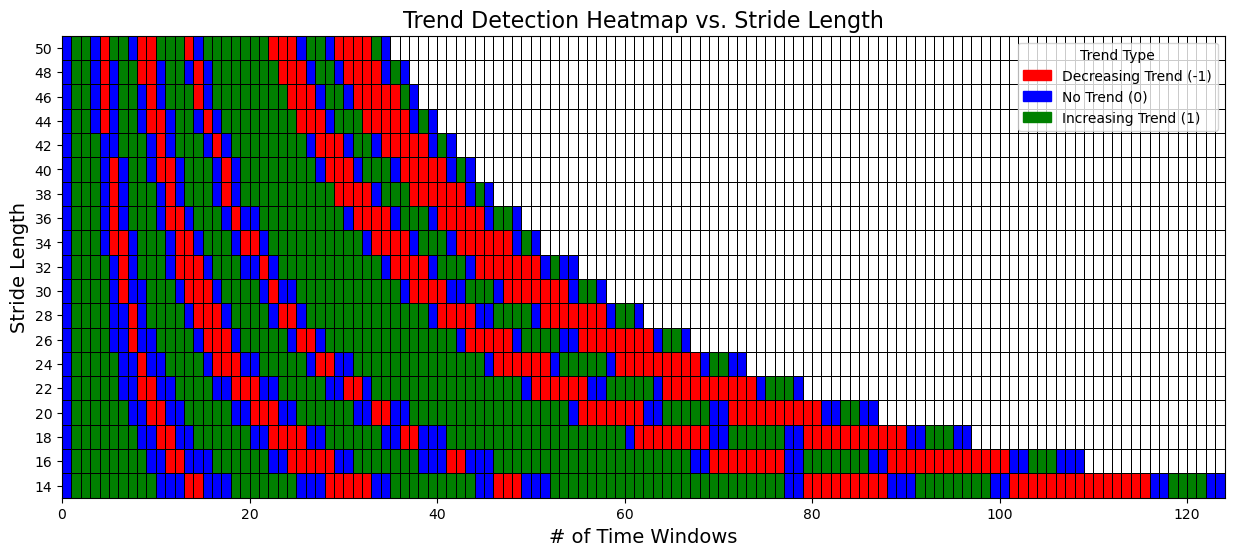

In [203]:
#from functions import heatmap
from functions import heatmap
stride_values = list(range(14, 52, 2))
chunk_size=192
heatmap(stride_values, chunk_size, start_index, end_index, df)

In [ ]:
#from functions import z_statistic
z_statistic(chunk_size, start_index, end_index, df, gif=False)

![An example of trending asset](Fig/Z-statistics.jpeg)

This plot shows that the results match the expectations: even if there are some local variations, since they are reasonable, the "global" traces convey stability.<br>
A real-life application can now be explpored: let's apply the test on a rolling basis, with the rolling stride euqal to 1:

The color code is the same of the heatmap.<br>
The 'gif==True' option creates this plot dynamically and this is the result it produces:

<img src="Fig/GIF.gif" width="1000">

The functions used to create the heatmap and the "real-life" application of the test are the following two:

In [205]:
def heatmap(stride_values, start_index, end_index, chunk_size, df):
    """
    function to partially assess the stability of the test.
    This is done via applying the test on a rolling basis, but starting from a stride between intervals much bigger than 1,
    and then progressively decreasing it.
    """
    test_results_matrix = []
    for rolling_stride in stride_values:
        test_results = []
        z_stat=[]
        significance=[]
        prices_filtered = filter_signal_by_auc(df['HA_close'][start_index:end_index].values, df[start_index:end_index].index,plot_spectrum=False)
        for start_idx in range(start_index, end_index - chunk_size + 1, rolling_stride):
            end_idx = start_idx + chunk_size

            # Apply Mann-Kendall Trend Test
            trend_test_modified = yue_wang_modification_test(prices_filtered[start_idx:end:idx])
            significance.append(trend_test_modified[1])
            z_stat.append(trend_test_modified[3])

            # Save test results as numerical values for plotting
            if trend_test_modified[0] == 'no trend':
                test_results.append(0)
            elif trend_test_modified[0] == 'increasing':
                test_results.append(1)
            else:
                test_results.append(-1)

        # Pad test_results to match the maximum length, needed bc we'll convert test_results_matrix into an array --> uniform len needed
        max_length = max(len(tr) for tr in test_results_matrix) if test_results_matrix else len(test_results)
        while len(test_results) < max_length:
            test_results.append(np.nan)  # Use np.nan to indicate missing values

        test_results_matrix.append(test_results)

    test_results_matrix = np.array(test_results_matrix)

    # Plot the heatmap with custom settings
    plt.figure(figsize=(15, 6))
    custom_cmap = ListedColormap(['red', 'blue', 'green'])
    mesh = plt.pcolormesh(
        test_results_matrix,
        cmap=custom_cmap,
        linewidths=0.5,
        edgecolors='black',

    )
    # Add a custom legend
    legend_patches = [
        mpatches.Patch(color='red', label='Decreasing Trend (-1)'),
        mpatches.Patch(color='blue', label='No Trend (0)'),
        mpatches.Patch(color='green', label='Increasing Trend (1)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', title="Trend Type")
    plt.yticks(ticks=np.arange(0.5, len(stride_values)), labels=stride_values)
    plt.xlabel('# of Time Windows', fontsize=14)
    plt.ylabel('Stride Length',fontsize=14)
    plt.title('Trend Detection Heatmap vs. Stride Length',fontsize=16)
    plt.show()

def z_statistic(chunk_size, start_index, end_index, df, gif=False):
    '''
    function to apply the Mann Kendall test on a rolling basis and to properly display the result
    '''
    def compute_stat(x):
        return yue_wang_modification_test(x)[3]
    def compute_significance(x):
        return yue_wang_modification_test(x)[1]
    def p_value_to_z(p_value): #convert the pvalue to the corrisponding value of the statistic
        return norm.ppf(1 - p_value / 2)


    df_filtered = df['HA_close'][start_index:end_index].copy()
    df_filtered = filter_signal_by_auc(df_filtered.values, df_filtered.index)
    df_filtered = df_filtered[start_index+10:end_index-10]
    df_filtered=df_filtered.to_frame(name='HA_close')

    df_filtered['stat']=df_filtered['HA_close'].rolling(window=chunk_size, min_periods=3).apply(compute_stat)
    df_filtered['significance']=df_filtered['HA_close'].rolling(window=chunk_size, min_periods=3).apply(compute_significance)

    significant=df_filtered['stat'][df_filtered['significance'] > 0]
    not_significant=df_filtered['stat'][df_filtered['significance'] < 1]
    z_bound=p_value_to_z(0.05) #0.05 because we choose a CI of 95%

    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [3,1]})
    fig.tight_layout()

    ax[0].plot(df_filtered['HA_close'])
    xcoords=range(start_index,end_index,chunk_size)
    xcoords=df.index[xcoords]
    for xc in xcoords:
        for a in ax:
            a.axvline(x=xc, color='grey', linestyle='--', linewidth=1, alpha=.5)
            a.grid(visible=False)
    ax[0].set_ylabel('price')

    ax[1].scatter(df_filtered['stat'].index[:],df_filtered['stat'], s=.5, label='z-statistic')
    ax[1].axhline(y=z_bound, color='black', linestyle='--', alpha=.5)
    ax[1].axhline(y=-z_bound, color='black', linestyle='--', alpha=.5, label='CI=95%')
    ax[1].axhspan(z_bound, ax[1].get_ylim()[1], facecolor='green', alpha=0.2)
    ax[1].axhspan(-z_bound, z_bound, facecolor='blue', alpha=0.2)
    ax[1].axhspan(ax[1].get_ylim()[0], -z_bound, facecolor='red', alpha=0.2)
    ax[1].set_ylabel('z-statistic')
    ax[1].legend()

    if(gif==True):
        fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [3,1]})
        fig.tight_layout()

        def update(frame):
            ax[0].cla()  # Clear previous plot
            ax[1].cla()  # Clear previous plot

            ax[0].set_ylabel('price')
            ax[1].set_ylabel('z-statistic')

            # Highlight rolling window in ax[0] (gray shading and vertical lines)
            start_idx = frame
            end_idx = start_idx + chunk_size
            if end_idx < len(df_filtered):
                ax[0].plot(df_filtered['HA_close'], label="HA_close")
                ax[0].axvspan(df_filtered.index[start_idx], df_filtered.index[end_idx], color='gray', alpha=0.3)
                ax[0].axvline(df_filtered.index[start_idx], color='red', linestyle='--', linewidth=1)
                ax[0].axvline(df_filtered.index[end_idx], color='red', linestyle='--', linewidth=1)

            # In ax[1], plot the computed stats and show window as well
            ax[1].scatter(df_filtered.index[:end_idx], df_filtered['stat'][:end_idx], s=0.5, label="z-statistic")
            if end_idx < len(df_filtered):
                ax[1].axvspan(df_filtered.index[start_idx], df_filtered.index[end_idx], color='gray', alpha=0.3)
            # Show the z-boundaries for significance in ax[1]
            ax[1].axhline(y=z_bound, color='black', linestyle='--', alpha=0.5)
            ax[1].axhline(y=-z_bound, color='black', linestyle='--', alpha=0.5, label='no trend (CI=95%)')
            ax[1].axhspan(z_bound, ax[1].get_ylim()[1], facecolor='green', alpha=0.2)
            ax[1].axhspan(-z_bound, z_bound, facecolor='blue', alpha=0.2)
            ax[1].axhspan(ax[1].get_ylim()[0], -z_bound, facecolor='red', alpha=0.2)
            ax[1].legend()

            return ax

        # Set the number of frames based on the rolling window size and length of df_filtered['stat']
        num_frames = len(df_filtered['stat']) - chunk_size

        # Animation setup
        ani = FuncAnimation(fig, update, frames=range(0, num_frames), interval=200, repeat=False)

        fig.suptitle('Prices vs z-stat')
        ax[0].set_ylabel('price')
        ax[1].set_ylabel('z-statistic')

        # Save the animation as a gif
        ani.save('rolling_computation_evolution.gif', writer='Pillow', fps=9)

Considering what has been said so far, we believe that the Mann Kendall test is reliable enough to determine the portions of the time series where the de-trending algorithm should be applied, preliminarily at least.

# De-trending algorithms

## Rolling mean

We now try to detrend the data by subtracting rolling means.


In particular we find an optimal timewindow w which corresponds to a given cutoff on the cumulative spectrum (in our case we chose 10%)

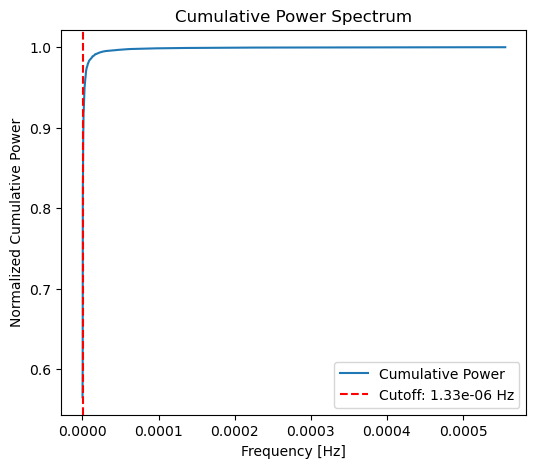

In [206]:
from functions import *
# Load the data

#file="data_M15/DAX_M15_202005242300_202411131015.csv"
file="data_M15/DJ_M15_202009240845_202411131015.csv"
_, close_data = import_data(file)

# We consider a 2 day interval
#t_min = pd.to_datetime('2020.05.25 09:15:00')
t_min = pd.to_datetime('2020.09.24 08:45:00')
t_min = close_data.index.get_loc(t_min)

#t_max = pd.to_datetime('2020.08.25 09:15:00')
t_max = pd.to_datetime('2020.12.24 08:45:00')
t_max = close_data.index.get_loc(t_max)

# Extract the signal and its datetime index
sig = close_data[t_min:t_max]
datetime_index = close_data.index[t_min:t_max]

# Call the filter_signal function from functions module
#filtered_sig_series = functions.filter_signal(sig, datetime_index, time_step=15*60, freq_factor=10)
filtered_sig_series=filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=False)
filter_signal(sig, datetime_index);

filtered_sig =filtered_sig_series

filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.1, plot_spectrum=True);

#Get the cutoff period -> frequency
cutoff=1/(get_period(sig,0.01)*900)

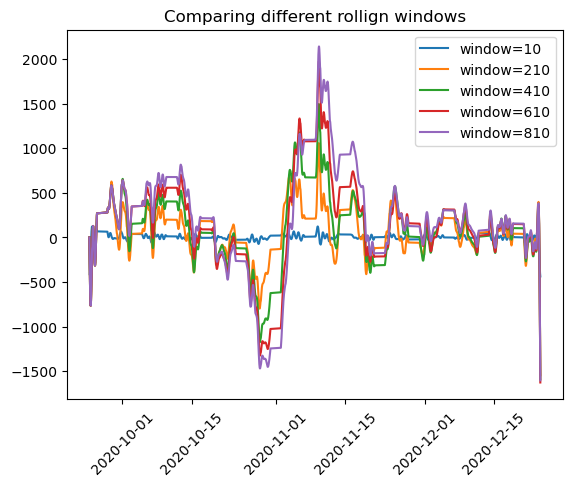

In [207]:
#plt.plot(filtered_sig, label="filtered signal")
for w in range(10,1000,200):
    plt.plot(filtered_sig-filtered_sig.rolling(window=w, min_periods=1, center=False).mean(), label=f"window={w}")
plt.xticks(rotation=45)
plt.title("Comparing different rollign windows")
plt.legend()
plt.show()

## Determining best window

Here we implement a function to find an optimal timewindow w which corresponds to a given cutoff on the cumulative spectrum

```python
def get_period(sig,discard_fraction=0.1,time_step=15*60):
    """
    Determines the cutoff frequency for filtering based on the area under the curve (AUC).

    Parameters:
    sig (array-like): The input signal.
    time_step (float): The time step (in seconds) between each data point (default is 15 minutes).
    discard_fraction (float): Fraction of the total power to discard (default is 10%).

    Returns:
    float: The cutoff frequency in Hz.
    """
    # Compute the corresponding frequencies
    sample_freq = fftfreq(len(sig), d=time_step)
    pos_mask = sample_freq > 0
    freqs = sample_freq[pos_mask]

    # Perform FFT
    sig_fft = fft(np.array(sig))
    power = np.abs(sig_fft) ** 2

    # Compute cumulative power
    cumulative_power = np.cumsum(power[pos_mask])
    total_power = cumulative_power[-1]
    target_power = (1 - discard_fraction) * total_power

    # Determine the cutoff frequency
    cutoff_idx = np.searchsorted(cumulative_power, target_power)
    
    # Return the corresponding frequency
    cutoff_freq= freqs[cutoff_idx] if cutoff_idx < len(freqs) else freqs[-1]
    
    return int(1/cutoff_freq * 1/time_step)

```



In [208]:
w=get_period(filtered_sig)
print("Rolling mean optimal period: ",w)

Rolling mean optimal period:  972


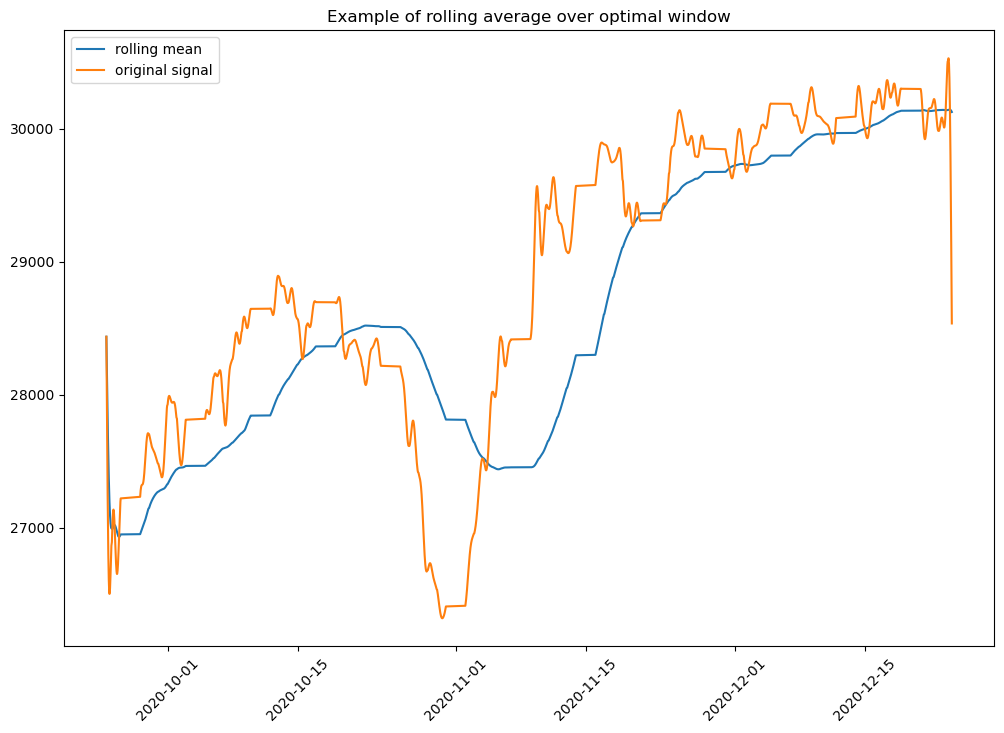

In [209]:
plt.figure(figsize=(12,8))
plt.plot(filtered_sig.rolling(window=int(w), min_periods=1, center=False).mean(), label="rolling mean")
plt.plot(filtered_sig,label="original signal")
plt.xticks(rotation=45)
plt.title("Example of rolling average over optimal window")
plt.legend()
plt.show()

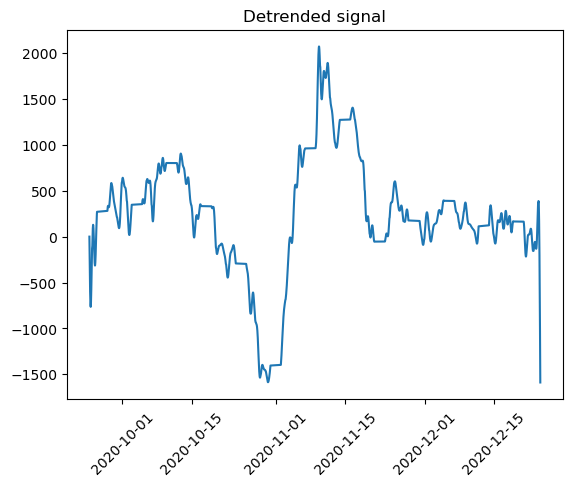

In [210]:
plt.plot(filtered_sig-filtered_sig.rolling(window=w, min_periods=1, center=False).mean())
plt.title("Detrended signal")
plt.xticks(rotation=45)
plt.show()

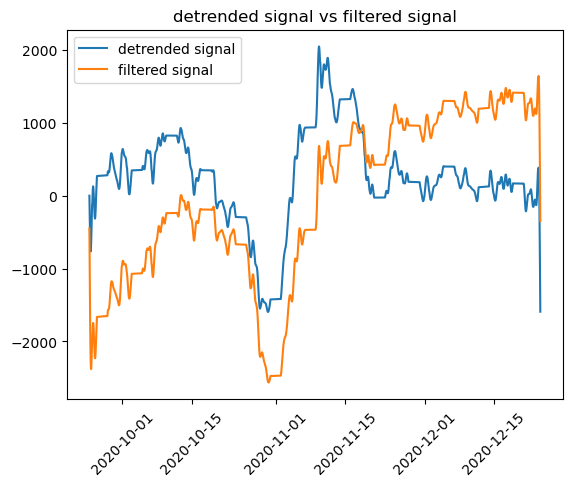

In [211]:
plt.plot(filtered_sig-filtered_sig.rolling(window=1000, min_periods=1, center=False).mean(),label="detrended signal")
plt.plot(filtered_sig-np.mean(filtered_sig), label='filtered signal')
plt.xticks(rotation=45)
plt.title("detrended signal vs filtered signal")
plt.legend()
plt.show()

## Test

We try the algorithm on the same data generated to test the Hurst exponent

Period:  71


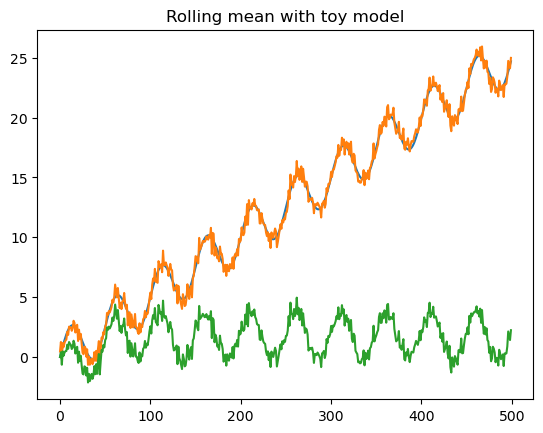

In [212]:
#Trial for final explaination

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hurst import compute_Hc

def generate_series(n, trend_slope=0.1, oscillation_amplitude=1.0, noise_level=0.0):
    t = np.arange(n)
    trend = trend_slope * t
    oscillation = oscillation_amplitude * np.sin(2 * np.pi * t / 50)
    noise = np.random.normal(scale=noise_level, size=n)
    return trend + oscillation + noise

def linear_detrend(series):
    t = np.arange(len(series))
    slope, intercept, _, _, _ = linregress(t, series)
    return series - (slope * t + intercept)

def analyze_series(data, title_prefix):
    hurst_lib, _, _ = compute_Hc(data, kind='random_walk', simplified=False)
    hurst_custom = hurst_exponent(data)
    detrended_data = linear_detrend(data)
    hurst_lib_detrended, _, _ = compute_Hc(detrended_data, kind='random_walk', simplified=False)
    hurst_custom_detrended = hurst_exponent(detrended_data)

    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} | Hurst: Orig (Lib={hurst_lib:.3f}, Custom={hurst_custom:.3f}), "
              f"Detrended (Lib={hurst_lib_detrended:.3f}, Custom={hurst_custom_detrended:.3f})")
    plt.show()

np.random.seed(42)
N=500 #length of time series
data_clean = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.0)
plt.plot(data_clean)
data_noisy = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.5)
plt.plot(data_noisy)


w=get_period(data_noisy)
print("Period: ",w)

plt.plot(data_noisy-pd.Series(data_noisy).rolling(window=int(w), min_periods=1, center=False).mean())
plt.title("Rolling mean with toy model")
plt.show()

In this case we are able to detrend the data

## Detrend the time series

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymannkendall import hamed_rao_modification_test
from scipy.fftpack import fft, ifft, fftfreq
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from numpy.polynomial.polynomial import Polynomial
import time
from functions import *
#plt.style.use("ggplot")

In [214]:
def process_time_series(
    file_path,
    base_chunk_size,
    start_index,
    end_index,
    time_step=15*60,
    discard_fraction=0.01,
    plot_spectrum=False):

    df_range = df.iloc[start_index:end_index].copy()
    def filter_signal_by_auc(sig, datetime_index, time_step=15*60, discard_fraction=0.1,plot_spectrum=False):
        # The corresponding frequencies
        sample_freq = fftfreq(sig.size, d=time_step)
        pos_mask = sample_freq > 0
        freqs = sample_freq[pos_mask]

        # Perform the FFT
        sig_fft = fft(np.array(sig))
        power = np.abs(sig_fft) ** 2

        # Compute cumulative power
        cumulative_power = np.cumsum(power[pos_mask])
        total_power = cumulative_power[-1]
        target_power = (1 - discard_fraction) * total_power

        # Determine the cutoff frequency
        cutoff_idx = np.searchsorted(cumulative_power, target_power)
        cutoff_freq = freqs[cutoff_idx]

        # Apply the frequency filter
        filtered_fft = sig_fft.copy()
        filtered_fft[np.abs(sample_freq) > cutoff_freq] = 0
        filtered_sig = ifft(filtered_fft)

        # Convert filtered signal to real values (IFFT output might be complex)
        filtered_sig = np.real(filtered_sig)

        # Create a Pandas Series with the datetime index and the filtered signal
        filtered_sig_series = pd.Series(filtered_sig, index=datetime_index)

        if(plot_spectrum==True):
            # Plot for visualization
            plt.figure(figsize=(6, 5))
            plt.plot(freqs, np.cumsum(power[pos_mask]) / total_power, label="Cumulative Power")
            plt.axvline(cutoff_freq, color='red', linestyle='--', label=f"Cutoff: {cutoff_freq:.2e} Hz")
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Normalized Cumulative Power')
            plt.title("Cumulative Power Spectrum")
            plt.legend()
            plt.show()

        return filtered_sig_series

    def compute_trend_strength(series, window):
        """Computes a rolling trend strength based on the slope of linear regression."""
        slopes = []
        arr = series.values
        for i in range(len(arr) - window + 1):
            x = np.arange(window)
            y = arr[i:i + window]
            slope, _, _, _, _ = linregress(x, y)
            slopes.append(abs(slope))  # Absolute slope as trend strength
        return np.concatenate([[0] * (window - 1), slopes])
    def adaptive_chunk_size(series, base_chunk, max_chunk, trend_threshold):
        """Adjusts chunk size dynamically based on trend strength."""
        trend_strength = compute_trend_strength(series, window=base_chunk)
        chunk_sizes = []
        for t in trend_strength:
            if t > trend_threshold:
                chunk_sizes.append(min(max_chunk, int(base_chunk * (1 + t * 3))))
            else:
                chunk_sizes.append(base_chunk)
        return chunk_sizes
    chunk_sizes = adaptive_chunk_size(
        df_range['HA_close'],
        base_chunk=base_chunk_size,
        max_chunk=base_chunk_size*4,
        trend_threshold=0.001
    )

    # We'll store chunk start/end indices in this list
    chunk_indices = []

    idx = df_range.index[0]   # Start from the first datetime in df_range
    i   = 0                   # We'll move through the chunk_sizes array
    end_datetime = df_range.index[-1]

    while True:
        if i >= len(chunk_sizes):
            # If we've run out of chunk_sizes, break
            break
        current_chunk = chunk_sizes[i]
        s_time = idx
        row_pos = df_range.index.get_loc(s_time)
        e_pos = row_pos + current_chunk
        if e_pos >= len(df_range):
            e_pos = len(df_range) - 1  # Last valid position
        e_time = df_range.index[e_pos]
        chunk_indices.append((s_time, e_time))
        # Update for next iteration
        i = e_pos + 1  # move to next index in chunk_sizes
        if e_pos + 1 < len(df_range):
            idx = df_range.index[e_pos + 1]
        else:
            break
        if e_time == end_datetime:
            break
    checkpoint=hamed_rao_modification_test(df_range['HA_close'].values).trend
    if checkpoint == 'increasing' or checkpoint=='decreasing':
        test_result = []
        test_result_filtered = []
        for (start_time, end_time) in chunk_indices:
            segment = df_range.loc[start_time:end_time, 'HA_close']
        # Apply filtering to that chunk
            segment_filtered = filter_signal(segment, segment.index)
        # Mann-Kendall on raw segment
            mk_raw = hamed_rao_modification_test(segment.values)
            if mk_raw[0] == 'increasing':
                test_result.append(1)
            elif mk_raw[0] == 'decreasing':
                test_result.append(-1)
            else:
                test_result.append(0)
        # Mann-Kendall on filtered segment
            mk_filt = hamed_rao_modification_test(segment_filtered.values)
            if mk_filt[0] == 'increasing':
                test_result_filtered.append(1)
            elif mk_filt[0] == 'decreasing':
                test_result_filtered.append(-1)
            else:
                test_result_filtered.append(0)
        df_filtered = filter_signal(df_range['HA_close'], df_range.index)
        detrended_segments = []
        trend_regions = []
        trend_lines   = []

    # We'll track each chunk's results here
        for idx_chunk, (start_time, end_time) in enumerate(chunk_indices):
            segment = df_range.loc[start_time:end_time, 'HA_close'].values
            trend_flag = test_result_filtered[idx_chunk]
            s_pos = df_range.index.get_loc(start_time)
            e_pos = df_range.index.get_loc(end_time)
            length = (e_pos - s_pos) + 1
            x_vals = np.arange(length).reshape(-1, 1)
            if trend_flag != 0:
                # Trend: use linear regression
                model = LinearRegression()
                model.fit(x_vals, segment.reshape(-1, 1))
                trend_line = model.predict(x_vals).flatten()
                detrended_seg = segment - trend_line
                trend_regions.append((s_pos + start_index, e_pos + start_index + 1, trend_flag))
                trend_lines.append((s_pos + start_index, e_pos + start_index + 1, trend_line))
            else:
                # Mean-reverting: subtract mean
                detrended_seg = segment - np.mean(segment)
            detrended_segments.append(detrended_seg)
        # Combine all detrended segments into a single 1D array
        detrended_values = np.concatenate(detrended_segments)
        # Detrended index
        detrended_index = df_range.index[:len(detrended_values)]
        detrended_full  = pd.Series(detrended_values, index=detrended_index)
        fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 6))

        # Plot original data
        #mpf.plot(df[start_time:end_time], type='candle', ax=ax1, style='yahoo', volume=False)
        #ax1.set_title("Asset Price with Trend")
        ax1.plot(df_range.index, df_range['HA_close'], label='Original', color='orange')
        # Detrended data
        ax2.plot(detrended_index, detrended_full, label='Detrended', color='blue')
        ax2.axhline(0, linestyle="dashed", color="black", alpha=0.7)
        ax2.legend()

        # Highlight trend regions on the top plot
        for (s_idx, e_idx, trend) in trend_regions:
            color = 'green' if trend == 1 else 'red'
            # Convert back to timestamps
            s_time = df.index[s_idx]
            e_time = df.index[e_idx - 1]  # e_idx is exclusive
            ax1.axvspan(s_time, e_time, color=color, alpha=0.2)

        # Trend lines
        for (s_idx, e_idx, line) in trend_lines:
            s_time = df.index[s_idx]
            e_time = df.index[e_idx - 1]
            # We need the time index for the chunk
            x_range = pd.date_range(start=s_time, periods=len(line), freq='15T')
            ax1.plot(x_range, line, color='black', linestyle='dashed', linewidth=1.5)

        ax1.legend()
        plt.tight_layout()
        plt.show()
        return detrended_full, checkpoint

    if checkpoint == 'no trend':
        print('The time series is not trending ')
        segment= df_range['HA_close']
        detrended_full = segment - segment.mean()

        fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 6))

        ax1.plot(df_range['HA_close'], label='Original', color='orange')

        # Detrended data
        ax2.plot(detrended_full, label='Detrended', color='blue')
        ax2.axhline(0, linestyle="dashed", color="black", alpha=0.7)
        ax2.legend()

        ax1.legend()
        plt.tight_layout()
        plt.show()
        
        return detrended_full, checkpoint
def rolling_window_detrend(series, window=50):
    detrended = np.zeros_like(series)
    for i in range(len(series)):
        start = max(0, i - window // 2)
        end = min(len(series), i + window // 2)
        x = np.arange(end - start)
        y = series[start:end]
        coeffs = np.polyfit(x, y, 1)  # Linear fit
        trend = np.polyval(coeffs, x)
        detrended[start:end] = y - trend  # Subtract trend
    return detrended

In [215]:
file_path = "data_M15/SP500_M15_202009220000_202411131015.csv"
df = pd.read_csv(file_path, delimiter='\t')
df.rename(columns={
        '<DATE>': 'Date', '<TIME>': 'Time', '<OPEN>': 'Open', '<HIGH>': 'High',
        '<LOW>': 'Low', '<CLOSE>': 'Close', '<TICKVOL>': 'TickVol', '<VOL>': 'Volume', '<SPREAD>': 'Spread'
    }, inplace=True)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H:%M:%S')
df.set_index('datetime', inplace=True)
df['HA_close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df['HA_open']  = df['Open']
df['HA_high']  = df[['High', 'HA_open', 'HA_close']].max(axis=1)
df['HA_low']   = df[['Low', 'HA_open', 'HA_close']].min(axis=1)

The time series is not trending 


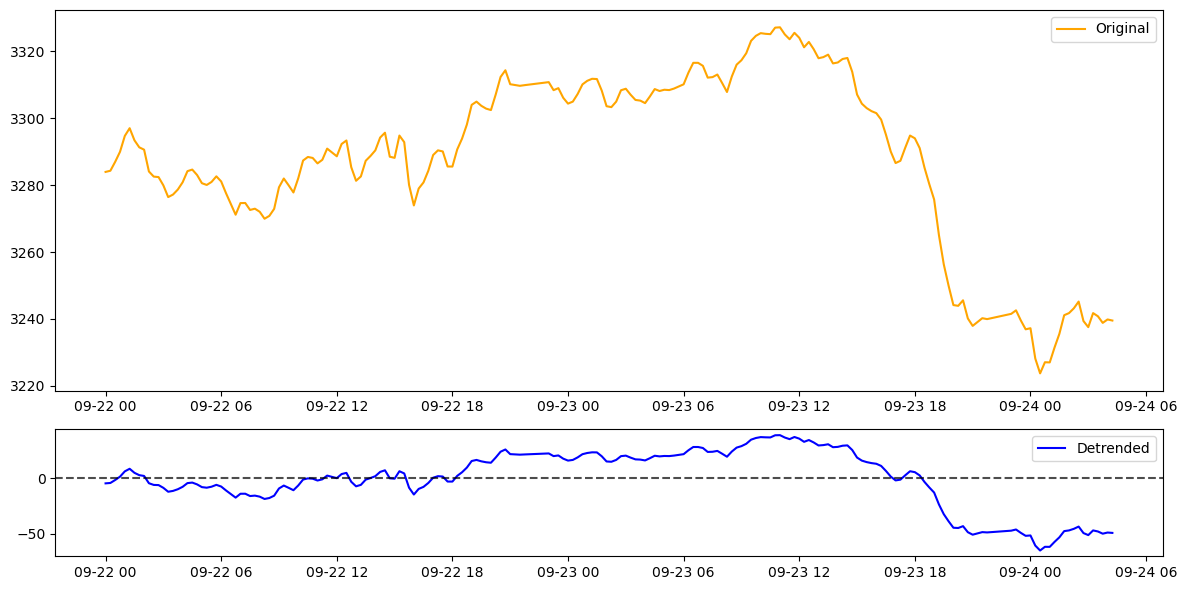

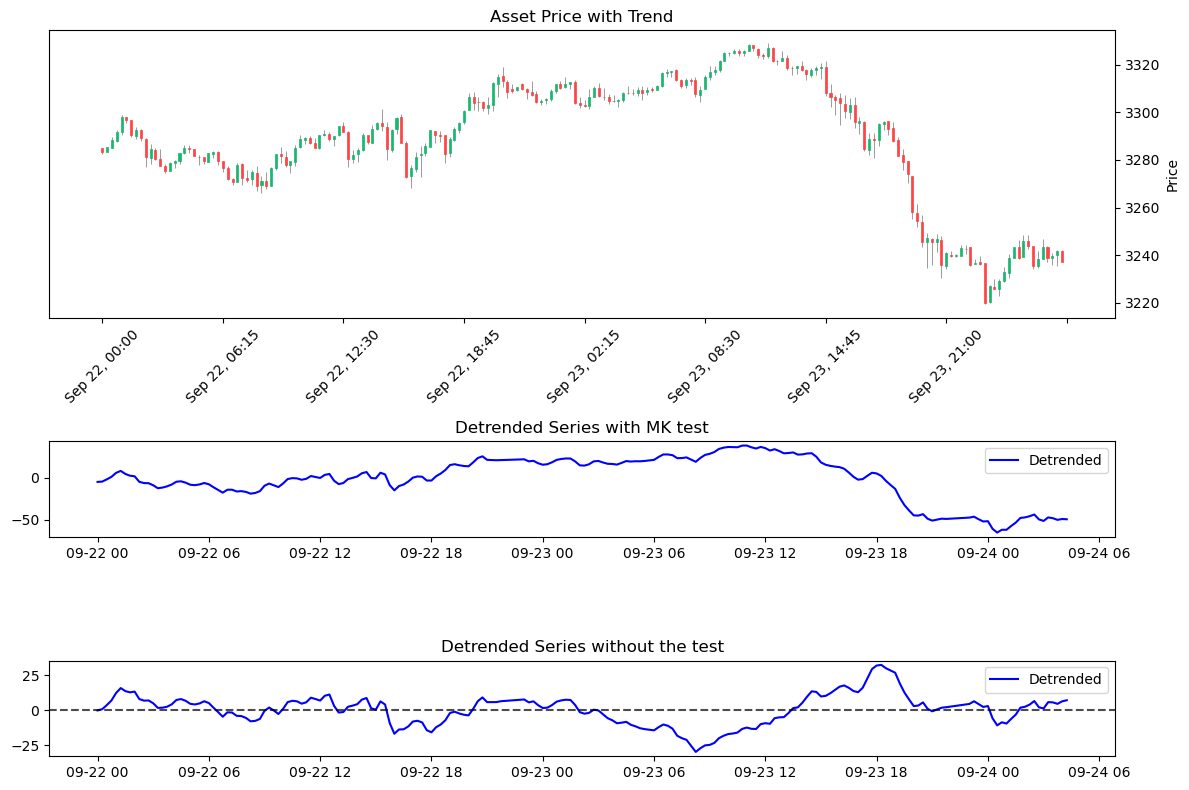

The time series is not trending 


<Figure size 640x480 with 0 Axes>

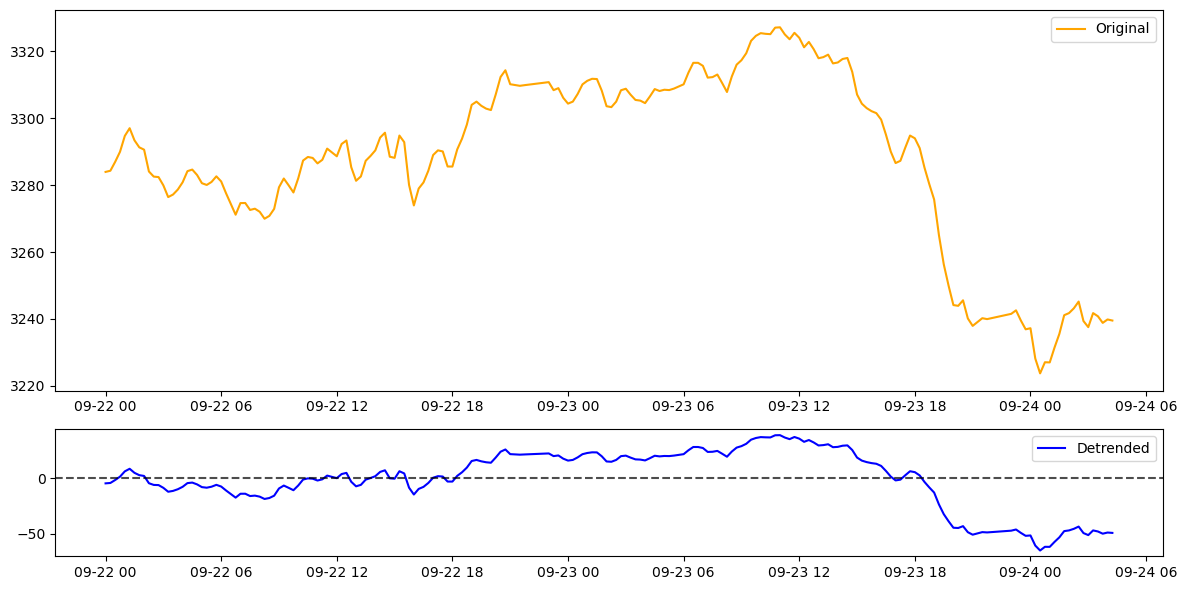

Mann-Kendall Detrending Time: 0.113443 seconds
Fit-and-Subtract Detrending Time: 2.104345 seconds


In [216]:
import mplfinance as mpf

start_time=0
end_time=200
detrended_full, checkpoint= process_time_series(file_path, base_chunk_size=50,start_index=start_time, end_index=end_time)
#############
df_range = df.iloc[start_time:end_time].copy()
############

fig, (ax1, ax2,ax3) = plt.subplots(3,1, gridspec_kw={'height_ratios': [3,1,1]}, figsize=(12,8))

# Main price chart (Candlestick)
mpf.plot(df[start_time:end_time], type='candle', ax=ax1, style='yahoo', volume=False)
ax1.set_title("Asset Price with Trend")
if checkpoint == 'no trend':
    ax2.plot(detrended_full, label="Detrended", color="blue")
    ax2.legend()
    ax2.set_title("Detrended Series with MK test")
else:
    # Detrended series subplot
    ax2.plot(detrended_full, label="Detrended", color="blue")
    ax2.axhline(0, linestyle="dashed", color="black", alpha=0.7)
    ax2.legend()
    ax2.set_title("Detrended Series with MK test")
df['detrended'] = rolling_window_detrend(df['HA_close'].values, window=50)
ax3.plot(df.index[start_time:end_time], df['detrended'][start_time:end_time], label="Detrended", color="blue")
ax3.axhline(0, linestyle="dashed", color="black", alpha=0.7)
ax3.legend()
ax3.set_title("Detrended Series without the test")

plt.tight_layout()
plt.show()
plt.tight_layout()

start_mk = time.perf_counter()
detrended_mk, checkpoint = process_time_series(file_path, base_chunk_size=50, start_index=start_time, end_index=end_time)
end_mk = time.perf_counter()

start_fit = time.perf_counter()
df['detrended_fit_subtract'] = rolling_window_detrend(df['HA_close'].values, window=50)
end_fit = time.perf_counter()

# Execution Time
mk_time = end_mk - start_mk
fit_time = end_fit - start_fit

print(f"Mann-Kendall Detrending Time: {mk_time:.6f} seconds")
print(f"Fit-and-Subtract Detrending Time: {fit_time:.6f} seconds")

We use again the Mann-Kendall test in the detreneded series to verify that the trend has been successufly substract


In [217]:
mk_test=hamed_rao_modification_test(detrended_full).trend
print(mk_test)

no trend


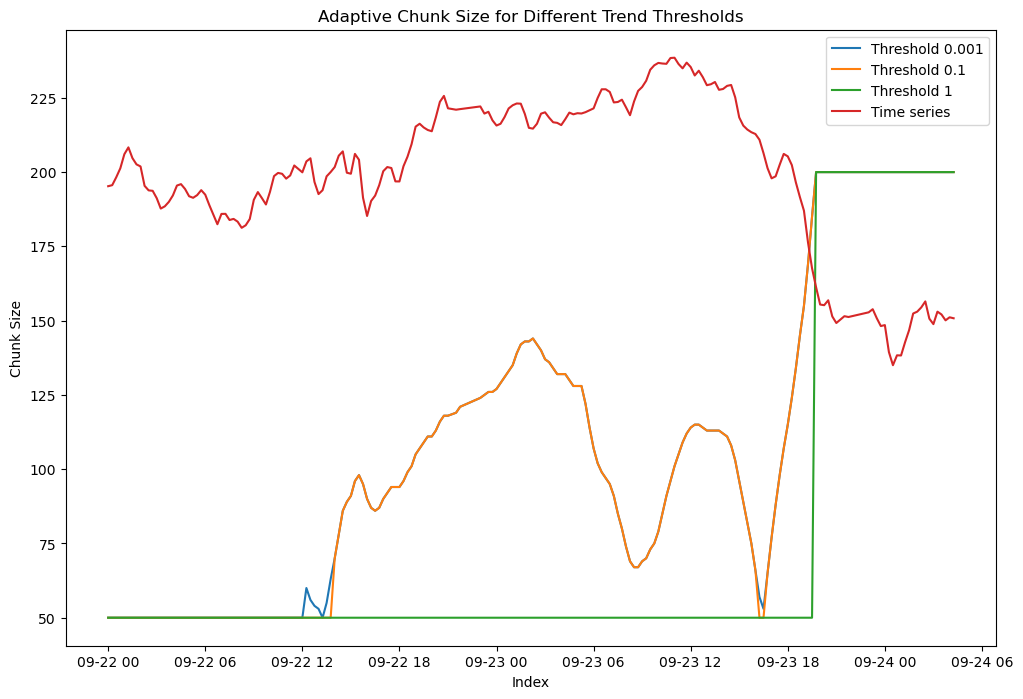

In [218]:
def compute_trend_strength(series, window):
    """Computes a rolling trend strength based on the slope of linear regression."""
    slopes = []
    arr = series
    for i in range(len(arr) - window + 1):
        x = np.arange(window)
        y = arr[i:i + window]
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(abs(slope))
    return np.concatenate([[0] * (window - 1), slopes])

def adaptive_chunk_size(timeseries, base_chunk, max_chunk, trend_threshold):
    """Adjusts chunk size based on local trend intensity."""
    trend_strength = compute_trend_strength(timeseries, window=base_chunk)
    chunk_sizes = []
    for t in trend_strength:
        if t > trend_threshold:
            chunk_sizes.append(min(max_chunk, int(base_chunk * (1 + t * 3))))
        else:
            chunk_sizes.append(base_chunk)
    return chunk_sizes

time_series = df_range['HA_close']

# Parameters
base_chunk_size = 50
max_chunk_size = base_chunk_size * 4
trend_thresholds = [0.001, 0.1,1]


plt.figure(figsize=(12, 8))

for threshold in trend_thresholds:
    chunk_sizes = adaptive_chunk_size(time_series, base_chunk_size, max_chunk_size, threshold)
    plt.plot(time_series.index,chunk_sizes, label=f"Threshold {threshold}")  # Use index for proper x-axis



plt.plot(detrended_full+200, label='Time series')
plt.xlabel("Index")
plt.ylabel("Chunk Size")
plt.legend()
plt.title("Adaptive Chunk Size for Different Trend Thresholds")
plt.show()

## Comparaison between Rolling Mean and Fit&Subtract

We can clearly observe a difference in the data.
The serie detrended with the rolling mean seem to "preserve" more the original structure of the data.

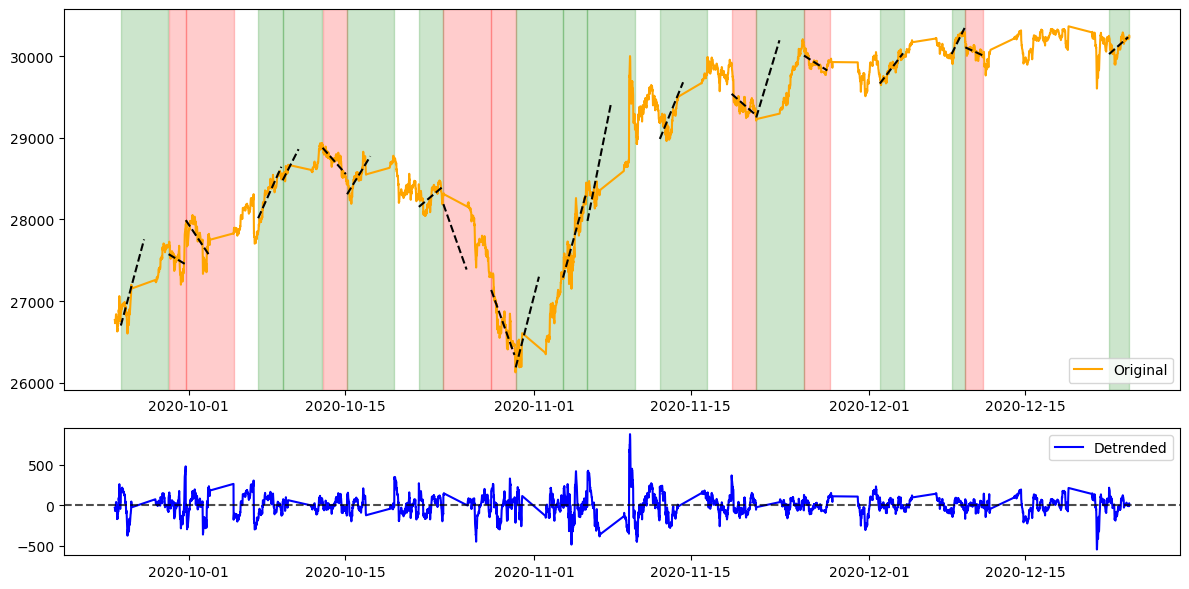

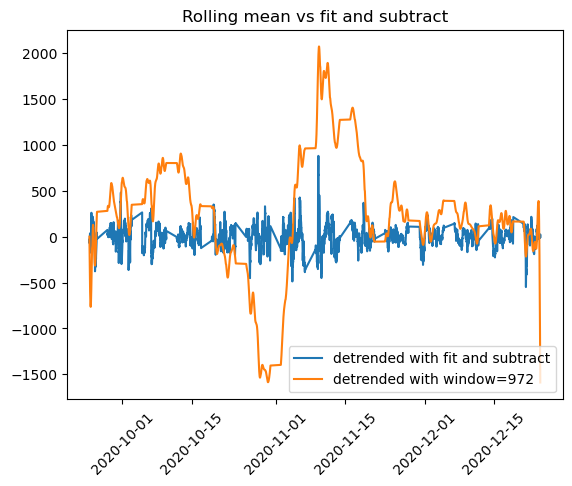

In [219]:
from functions import *
from sklearn.linear_model import LinearRegression

detrended,_=process_time_series(file,
    base_chunk_size=50,
    start_index=t_min,
    end_index=t_max)

w=int(get_period(filtered_sig))
plt.plot(detrended, label="detrended with fit and subtract")


plt.plot(filtered_sig-filtered_sig.rolling(window=w, min_periods=1, center=False).mean(), label=f"detrended with window={w}")
plt.xticks(rotation=45)
plt.title("Rolling mean vs fit and subtract")
plt.legend()
plt.show()

We try to quantify our intuition by looking at the spectrum

## Spectrum analysis

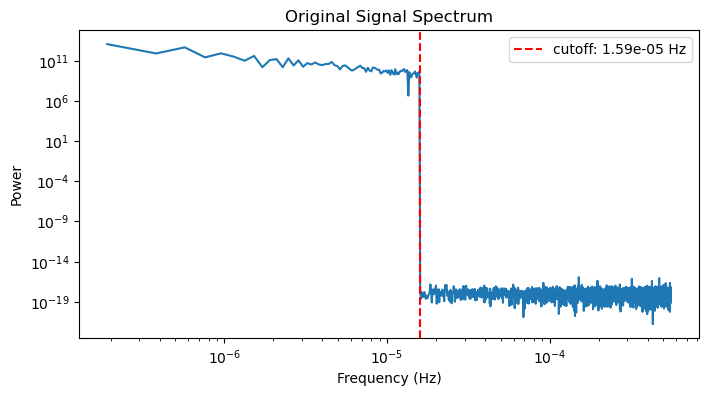

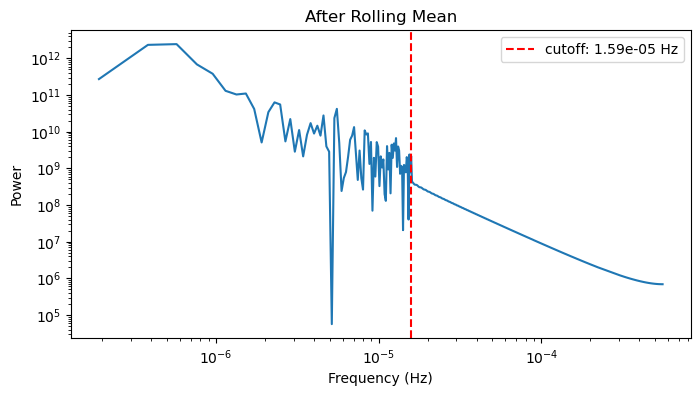

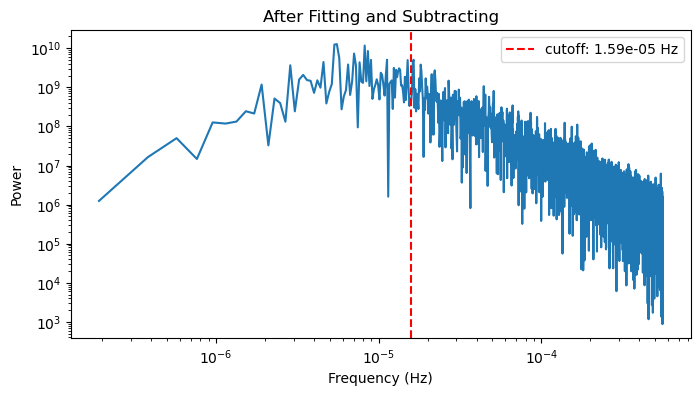

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(signal, title="Power Spectrum"):
    N = len(signal)
    time_step = 15*60  # 15 minutes in seconds
    freq = np.fft.fftfreq(N, d=time_step)  # Convert to Hz
    psd = np.abs(np.fft.fft(signal))**2  # Compute power spectral density

    plt.figure(figsize=(8, 4))
    plt.loglog(freq[freq > 0], psd[freq > 0])  # Convert Hz
    plt.axvline(cutoff, color='r', linestyle='--', label=f'cutoff: {cutoff:.2e} Hz')  # Vertical line
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.title(title)
    plt.show()

#filtered_sig_final=filter_signal_by_auc(filtered_sig - filtered_sig.rolling(window=1000,min_periods=1).mean(), datetime_index, time_step=15*60, discard_fraction=0.01, plot_spectrum=False)
final_sig=filtered_sig - filtered_sig.rolling(window=w,min_periods=1).mean()

plot_power_spectrum(filtered_sig, title="Original Signal Spectrum")
plot_power_spectrum(final_sig, title="After Rolling Mean")
plot_power_spectrum(detrended, title="After Fitting and Subtracting")

In [221]:
print("Original period: ", get_period(filtered_sig))
print("Rolling mean: ", get_period(final_sig))
print("Fit and subtract: ", get_period(detrended))

Original period:  972
Rolling mean:  833
Fit and subtract:  21


We can observe that the period has been significantly decreased for the

## Relative Oscillatory Energy (ROE) Calculation



### Overview
The **Relative Oscillatory Energy (ROE)** is a measure of how much energy a signal contains within a specific frequency band relative to its total energy. This is useful for analyzing the dominant frequency components of a time series.

### Method
The **Power Spectral Density (PSD)** of the signal is estimated using **Welch’s method**, which provides a robust frequency-domain representation of the signal. The energy in a given frequency range is computed by integrating the PSD over that range.

### Steps:
1. Compute the **PSD** using Welch's method.
2. Determine the **total energy** by integrating the PSD over all available frequencies.
3. Identify the **minimum nonzero frequency** (`f_low`) and a predefined **cutoff frequency** (`cutoff`).
4. Compute the **band-limited energy** by integrating the PSD in the range `[f_low, cutoff]`.
5. Compute the **ROE** as the ratio of band-limited energy to the total energy.

### Formula
Given the power spectral density $ P(f) $, the ROE is defined as:

$$
ROE = \frac{\int_{f_{\text{low}}}^{f_{\text{cutoff}}} P(f) \, df}{\int_{f_{\text{min}}}^{f_{\text{max}}} P(f) \, df}
$$

where:
- $ f_{\text{low}} $ is the smallest nonzero frequency in the PSD.
- $ f_{\text{cutoff}} $ is the predefined upper bound frequency.
- $ f_{\text{min}} $ and $ f_{\text{max}} $ are the minimum and maximum frequencies in the PSD.

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy import integrate

def compute_relative_oscillatory_energy(signal, fs, cutoff):
    """
    Compute the relative oscillatory energy (ROE) for a given time series using Welch's method.

    Parameters:
        signal (numpy.ndarray): 1D array containing the time series data.
        fs (float): Sampling frequency (in Hz).
        cutoff (float): Upper bound of the frequency band of interest.

    Returns:
        roe (float): Relative oscillatory energy.
        f (numpy.ndarray): Array of frequency bins.
        Pxx (numpy.ndarray): Estimated power spectral density corresponding to f.
    """
    # Compute the PSD using Welch's method
    nperseg = min(256, len(signal))
    f, Pxx = welch(signal, fs=fs, window='hann', nperseg=nperseg)

    # Define the lower bound as the minimum nonzero frequency
    f_low = np.min(f[f > 0])  # Smallest nonzero frequency

    # Total energy is the integral of the PSD over all frequencies.
    total_energy = np.trapz(Pxx, f)

    # Energy in the desired frequency band [f_low, cutoff]
    idx_band = np.logical_and(f >= f_low, f <= cutoff)
    band_energy = np.trapz(Pxx[idx_band], f[idx_band])

    roe = band_energy / total_energy if total_energy > 0 else np.nan
    return roe, f, Pxx

# Example usage
fs = 1 / (15 * 60)  # Sampling frequency (Hz), assuming a time step of 15 minutes

roe_original, f, Pxx = compute_relative_oscillatory_energy(filtered_sig, fs, cutoff)
roe_rolling, f, Pxx_rolling = compute_relative_oscillatory_energy(final_sig, fs, cutoff)
roe_detrended, f, Pxx_detrended = compute_relative_oscillatory_energy(detrended, fs, cutoff)

print(f"ROE (Original Signal): {roe_original:.4f}")
print(f"ROE (After Rolling Mean): {roe_rolling:.4f}")
print(f"ROE (After Detrending): {roe_detrended:.4f}")

ROE (Original Signal): 0.5664
ROE (After Rolling Mean): 0.5695
ROE (After Detrending): 0.4075


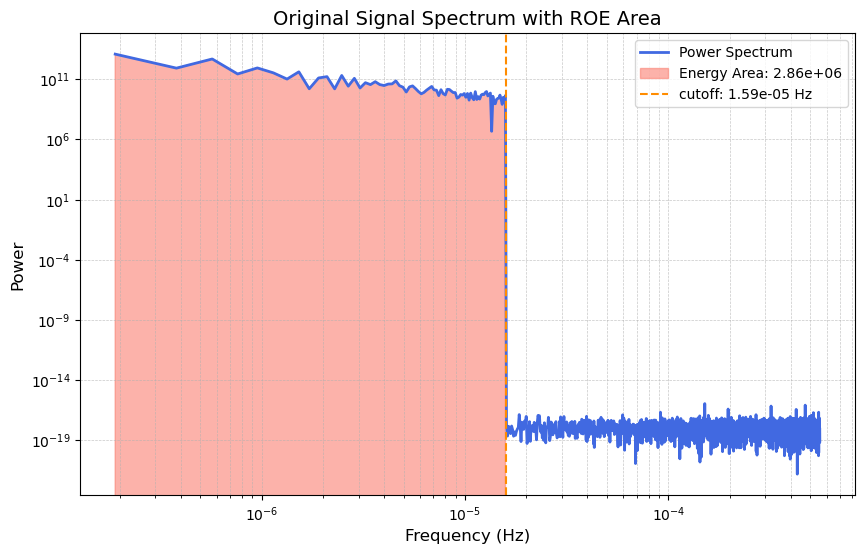

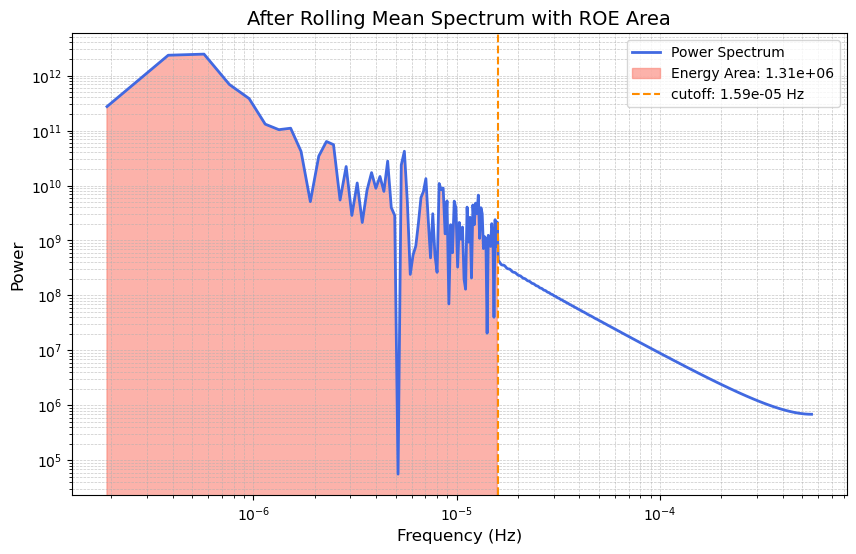

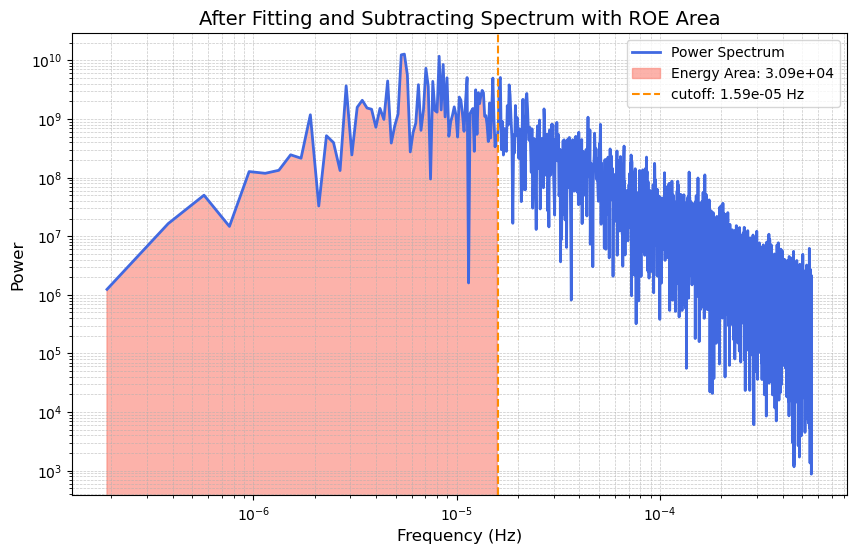

In [223]:
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum_with_area(signal, fs, cutoff, title="Power Spectrum"):
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/fs)  # Frequencies corresponding to the FFT
    Pxx = np.abs(np.fft.fft(signal))**2  # Power spectral density (FFT)

    # Only positive frequencies
    positive_freq_idx = freq > 0
    f = freq[positive_freq_idx]
    Pxx = Pxx[positive_freq_idx]

    # Area under the curve between f_low and cutoff
    f_low = np.min(f[f > 0])  # Smallest nonzero frequency
    idx_band = np.logical_and(f >= f_low, f <= cutoff)
    band_energy = np.trapz(Pxx[idx_band], f[idx_band])  # Energy in the frequency band

    # Plotting the power spectrum
    plt.figure(figsize=(10, 6))
    plt.loglog(f, Pxx, color='royalblue', label='Power Spectrum', linewidth=2)
    plt.fill_between(f[idx_band], Pxx[idx_band], color='salmon', alpha=0.6, label=f'Energy Area: {band_energy:.2e}')
    plt.axvline(cutoff, color='darkorange', linestyle='--', label=f'cutoff: {cutoff:.2e} Hz', linewidth=1.5)

    # Labels and Title
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Power", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.title(title, fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


# Example usage
fs = 1 / (15 * 60)  # Sampling frequency (in Hz), assuming a time step of 15 minutes

# Original signal
plot_power_spectrum_with_area(filtered_sig, fs, cutoff, title="Original Signal Spectrum with ROE Area")

# After rolling mean
plot_power_spectrum_with_area(final_sig, fs, cutoff, title="After Rolling Mean Spectrum with ROE Area")

# After detrending
plot_power_spectrum_with_area(detrended, fs, cutoff, title="After Fitting and Subtracting Spectrum with ROE Area")

Then, the aim of this project was to "design a method that removes the trending component of an asset’s time series and reveals its mean reverting properties". So once the trend has been removed we can determine whether the timeseries exhibits mean reversion, and we can do so by applying the metric, developed in the other section of this project, that reflects the degree of mean reversion of the asset. We use this metric on the results of all the algorithms developed, to comment on their performances.

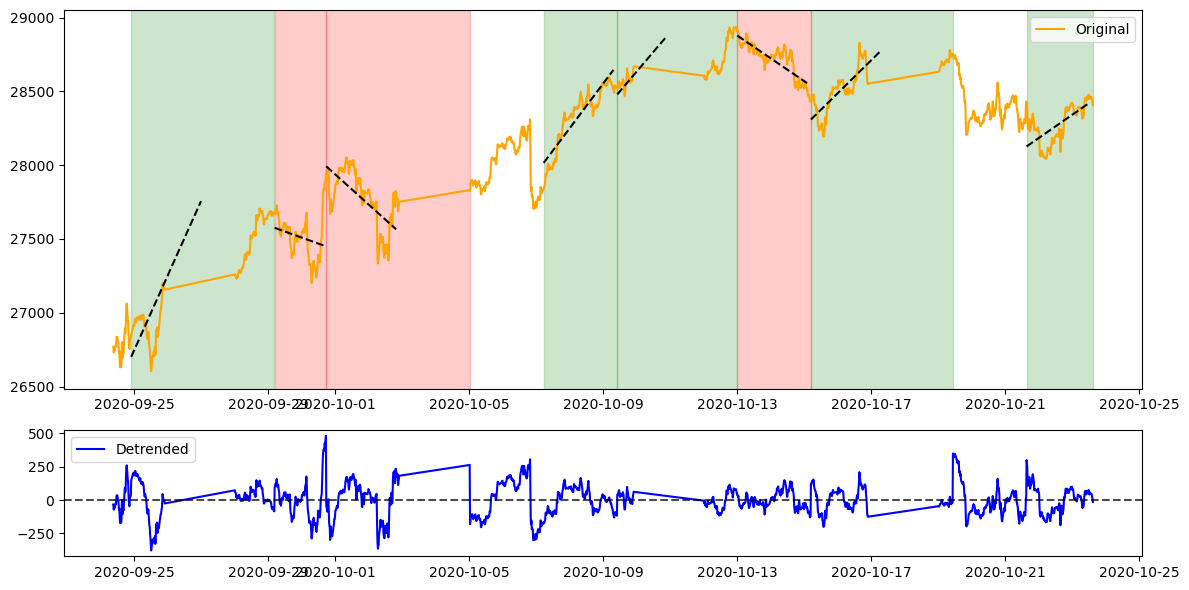

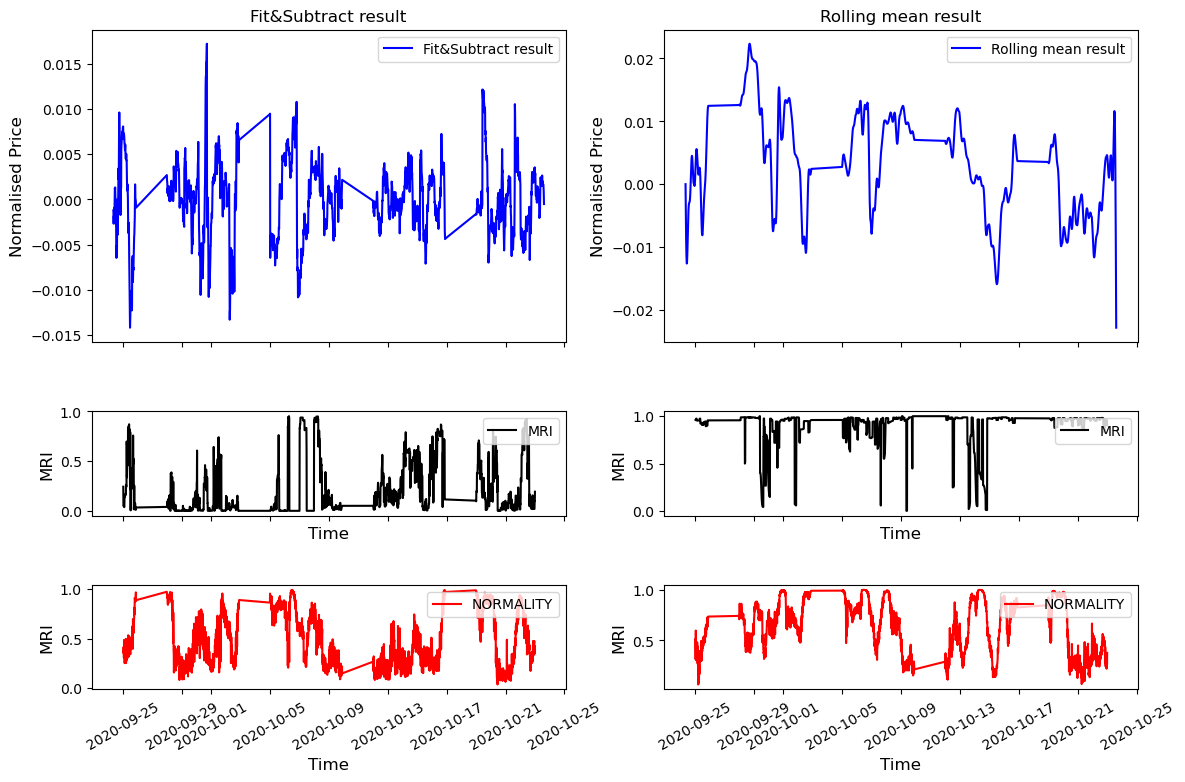

In [224]:
df,_=import_data(file)

detrended_full,_=process_time_series(
    file,
    base_chunk_size=50,
    start_index=96*0,
    end_index=96*20)

#ARIMA MRI
#fit&sub
df_fitsub=detrended_full
df_fitsub["rect"] = detrended_full/df["HA_close"][start_index:end_index]  #filtered_sig
#df_fitsub["rect"]=df_fitsub["rect"].dropna

window = 120
df_fitsub["amplitude"] = df_fitsub["rect"].rolling(window=window, center=True).apply(find_amplitudes, raw=True)
df_fitsub["volatility"] = df_fitsub["rect"].rolling(window=window, center=True).apply(volatility, raw=True)
df_fitsub["MRI"] = df_fitsub["rect"].rolling(window=window, center=True).apply(mean_revertion_index, raw=True)

#rolling mean
df_mean=df['HA_close'][start_index:end_index]
filtered_sig=filter_signal_by_auc(df_mean.values,df_mean.index, discard_fraction=0.01)
df_mean["rect"] = (filtered_sig-filtered_sig.rolling(window=get_period(filtered_sig), min_periods=1, center=False).mean())/(filtered_sig)

window = 120
df_mean["amplitude"] = df_mean["rect"].rolling(window=window, center=True).apply(find_amplitudes, raw=True)
df_mean["volatility"] = df_mean["rect"].rolling(window=window, center=True).apply(volatility, raw=True)
df_mean["MRI"] = df_mean["rect"].rolling(window=window, center=True).apply(mean_revertion_index, raw=True)

#Normal MRI
#fit&sub
df_fitsub["normality"] = df_fitsub["rect"].rolling(window = window, center = True).apply(assess_normality_rolling, raw=True, args = (int(window/8),) ) #2400 should be ok
#rolling mean
df_mean["normality"] = df_mean["rect"].rolling(window = window, center = True).apply(assess_normality_rolling, raw=True, args = (int(window/8),) ) #2400 should be ok

#plotting

data_labels = ["rect", "MRI", "normality"]
titles = ["Fit&Subtract result", "Rolling mean result"]
y_labels = ["Normalised Price", "MRI", "MRI"]
colors = ["blue", "black", "red"]

# Create figure with 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})
fig.tight_layout(pad=4)  # Adjust padding for better spacing

# Loop over rows (datasets, MRI, normality)
for row, label in enumerate(data_labels):
    for col, (df, title) in enumerate(zip([df_fitsub, df_mean], titles)):
        ax[row, col].plot(df[label], color=colors[row], label=title if row == 0 else label.upper())
        ax[row, col].set_title(title if row == 0 else "")
        ax[row, col].set_ylabel(y_labels[row], fontsize=12)
        ax[row, col].legend(loc='upper right')
        if row > 0:
            ax[row, col].set_xlabel('Time', fontsize=12)
            ax[row, col].tick_params(axis='x', rotation=30)  # Rotate x labels for MRI & normality rows

plt.show()

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymannkendall import hamed_rao_modification_test
from scipy.fftpack import fft, ifft, fftfreq
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from numpy.polynomial.polynomial import Polynomial
import time
#plt.style.use("ggplot")

In [226]:
#df_range = df.iloc[start_index:end_index].copy()

In [227]:
file_path = "data_M15/SP500_M15_202009220000_202411131015.csv"
df = pd.read_csv(file_path, delimiter='\t')
df.rename(columns={
        '<DATE>': 'Date', '<TIME>': 'Time', '<OPEN>': 'Open', '<HIGH>': 'High',
        '<LOW>': 'Low', '<CLOSE>': 'Close', '<TICKVOL>': 'TickVol', '<VOL>': 'Volume', '<SPREAD>': 'Spread'
    }, inplace=True)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H:%M:%S')
df.set_index('datetime', inplace=True)
df['HA_close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df['HA_open']  = df['Open']
df['HA_high']  = df[['High', 'HA_open', 'HA_close']].max(axis=1)
df['HA_low']   = df[['Low', 'HA_open', 'HA_close']].min(axis=1)

The time series is not trending 


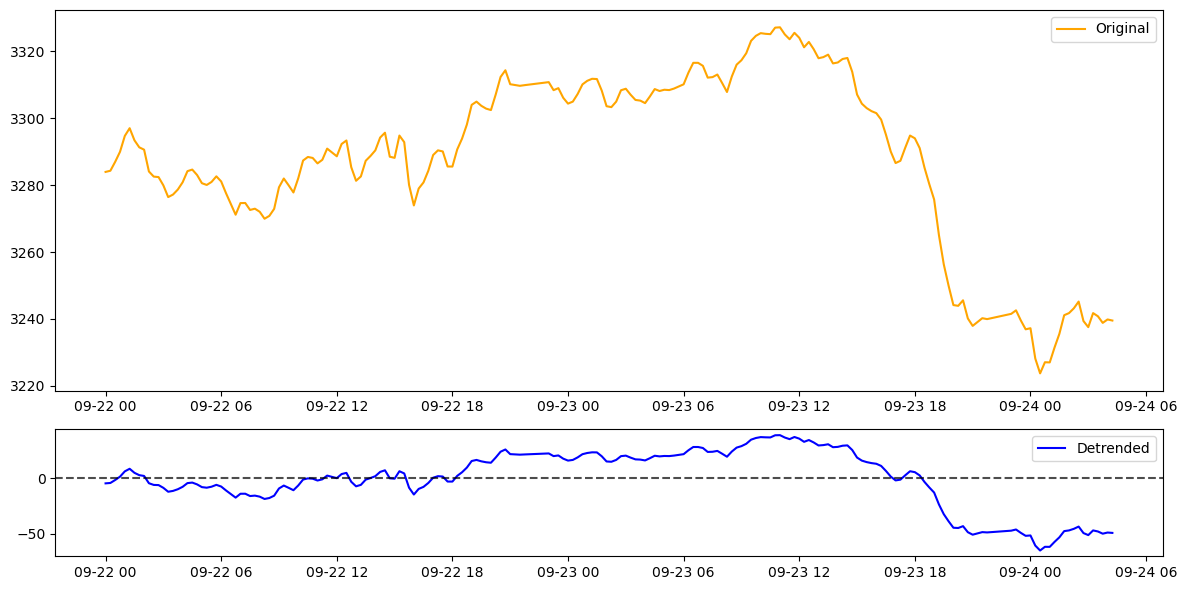

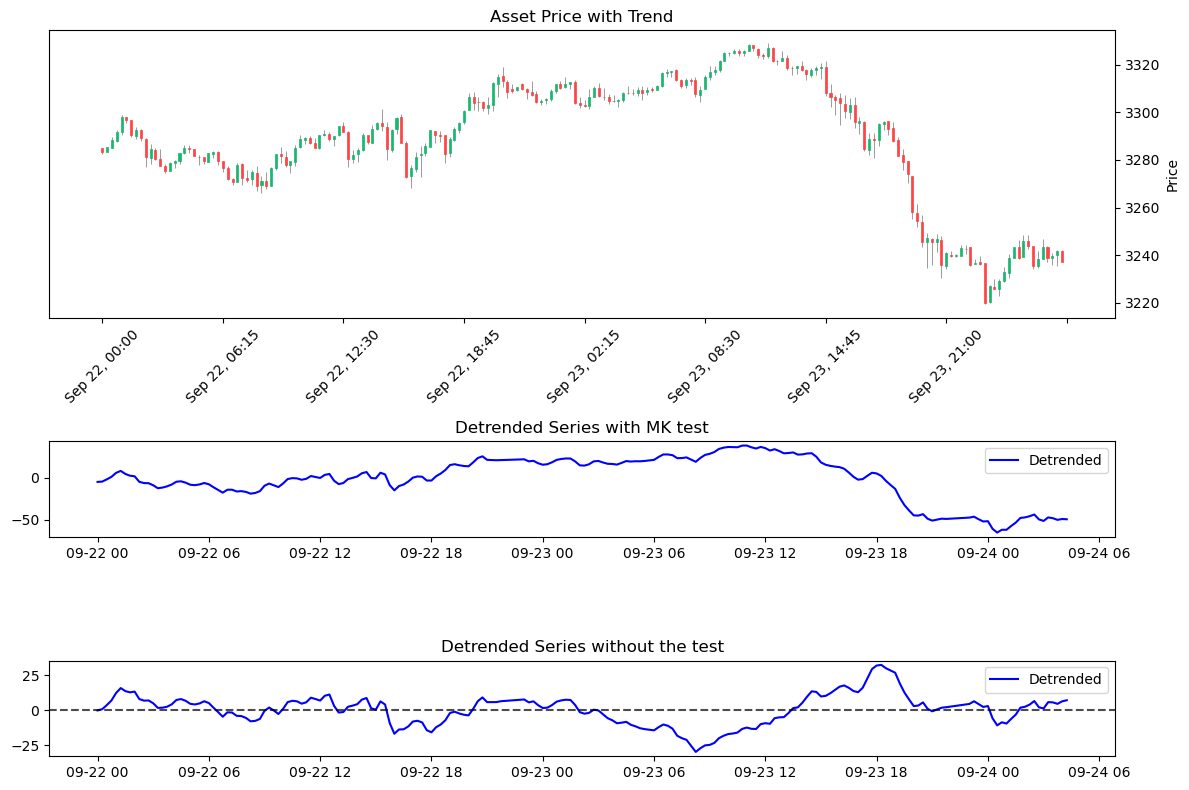

The time series is not trending 


<Figure size 640x480 with 0 Axes>

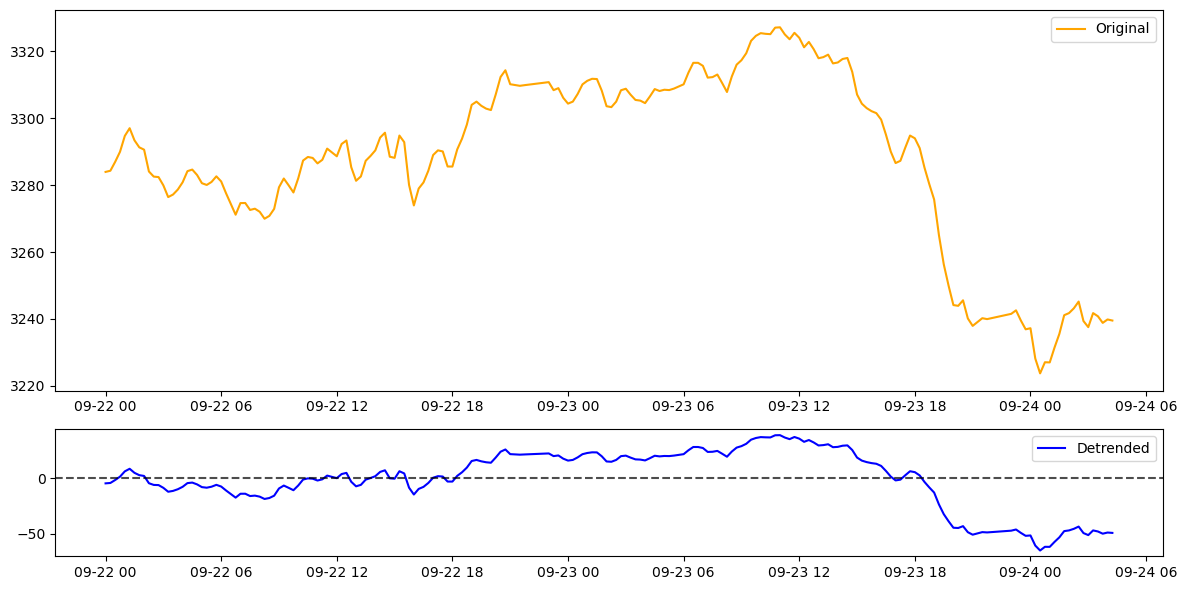

Mann-Kendall Detrending Time: 0.345957 seconds
Fit-and-Subtract Detrending Time: 1.979254 seconds


In [228]:
import mplfinance as mpf
from functions import *

start_time=0
end_time=200
detrended_full, checkpoint= process_time_series(file_path, base_chunk_size=50,start_index=start_time, end_index=end_time)
#############
df_range = df.iloc[start_time:end_time].copy()
############


fig, (ax1, ax2,ax3) = plt.subplots(3,1, gridspec_kw={'height_ratios': [3,1,1]}, figsize=(12,8))

# Main price chart (Candlestick)
mpf.plot(df[start_time:end_time], type='candle', ax=ax1, style='yahoo', volume=False)
ax1.set_title("Asset Price with Trend")
if checkpoint == 'no trend':
    ax2.plot(detrended_full, label="Detrended", color="blue")
    ax2.legend()
    ax2.set_title("Detrended Series with MK test")
else:
    # Detrended series subplot
    ax2.plot(detrended_full, label="Detrended", color="blue")
    ax2.axhline(0, linestyle="dashed", color="black", alpha=0.7)
    ax2.legend()
    ax2.set_title("Detrended Series with MK test")
df['detrended'] = rolling_window_detrend(df['HA_close'].values, window=50)
ax3.plot(df.index[start_time:end_time], df['detrended'][start_time:end_time], label="Detrended", color="blue")
ax3.axhline(0, linestyle="dashed", color="black", alpha=0.7)
ax3.legend()
ax3.set_title("Detrended Series without the test")

plt.tight_layout()
plt.show()
plt.tight_layout()

start_mk = time.perf_counter()
detrended_mk, checkpoint = process_time_series(file_path, base_chunk_size=50, start_index=start_time, end_index=end_time)
end_mk = time.perf_counter()

start_fit = time.perf_counter()
df['detrended_fit_subtract'] = rolling_window_detrend(df['HA_close'].values, window=50)
end_fit = time.perf_counter()

# Execution Time
mk_time = end_mk - start_mk
fit_time = end_fit - start_fit

print(f"Mann-Kendall Detrending Time: {mk_time:.6f} seconds")
print(f"Fit-and-Subtract Detrending Time: {fit_time:.6f} seconds")

We use again the Mann-Kendall test in the detreneded series to verify that the trend has been successufly substract


In [229]:
mk_test=hamed_rao_modification_test(detrended_full).trend
print(mk_test)

no trend


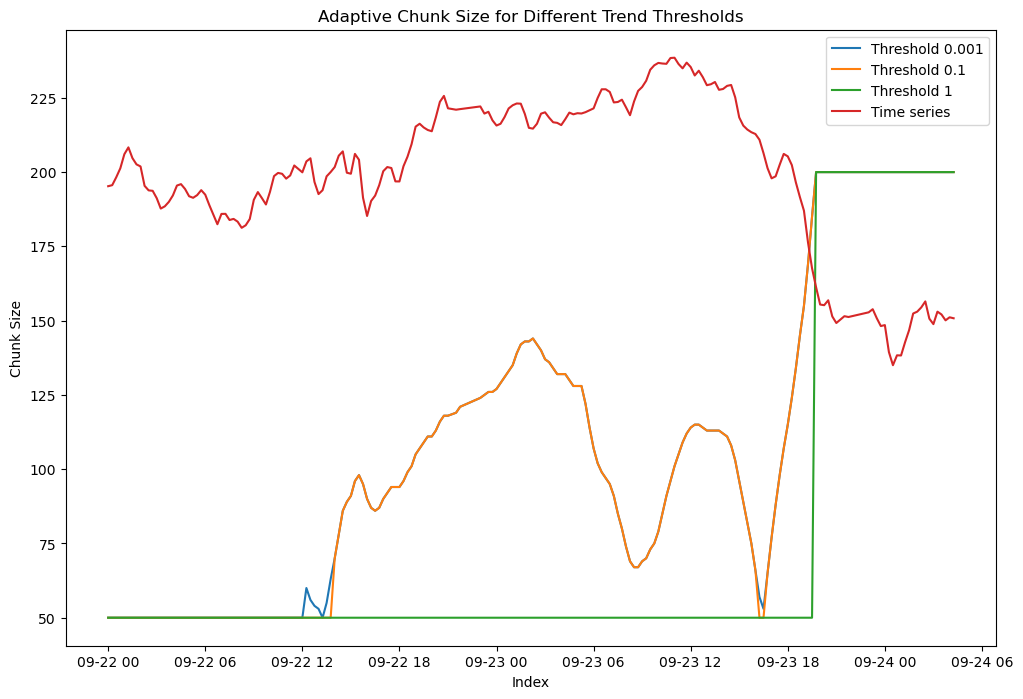

In [230]:
def compute_trend_strength(series, window):
    """Computes a rolling trend strength based on the slope of linear regression."""
    slopes = []
    arr = series
    for i in range(len(arr) - window + 1):
        x = np.arange(window)
        y = arr[i:i + window]
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(abs(slope))
    return np.concatenate([[0] * (window - 1), slopes])

def adaptive_chunk_size(timeseries, base_chunk, max_chunk, trend_threshold):
    """Adjusts chunk size based on local trend intensity."""
    trend_strength = compute_trend_strength(timeseries, window=base_chunk)
    chunk_sizes = []
    for t in trend_strength:
        if t > trend_threshold:
            chunk_sizes.append(min(max_chunk, int(base_chunk * (1 + t * 3))))
        else:
            chunk_sizes.append(base_chunk)
    return chunk_sizes

time_series = detrended_full

# Parameters
base_chunk_size = 50
max_chunk_size = base_chunk_size * 4
trend_thresholds = [0.001, 0.1,1]


plt.figure(figsize=(12, 8))

for threshold in trend_thresholds:
    chunk_sizes = adaptive_chunk_size(time_series, base_chunk_size, max_chunk_size, threshold)
    plt.plot(time_series.index,chunk_sizes, label=f"Threshold {threshold}")  # Use index for proper x-axis



plt.plot(detrended_full+200, label='Time series')
plt.xlabel("Index")
plt.ylabel("Chunk Size")
plt.legend()
plt.title("Adaptive Chunk Size for Different Trend Thresholds")
plt.show()

## Forecasting

We can plot the Autocorrelation (ACF) and Partial Autocorrelation (PACF) to know hidden patterns in our data. The autocorrelation measure the similarities between the time series and the lags given. Is describe as $$r_k=\frac{\sum_i^{N-k}(Y_i-Y)(Y_{i+K}-Y)}{\sum_i^N(Y_i+Y)^2}$$ Where k is the number of lags.
THe PACF in the other hand, evaluated the correlation between the time series own lagged values this clean the correlation values and let us inspect the relation with the past values.

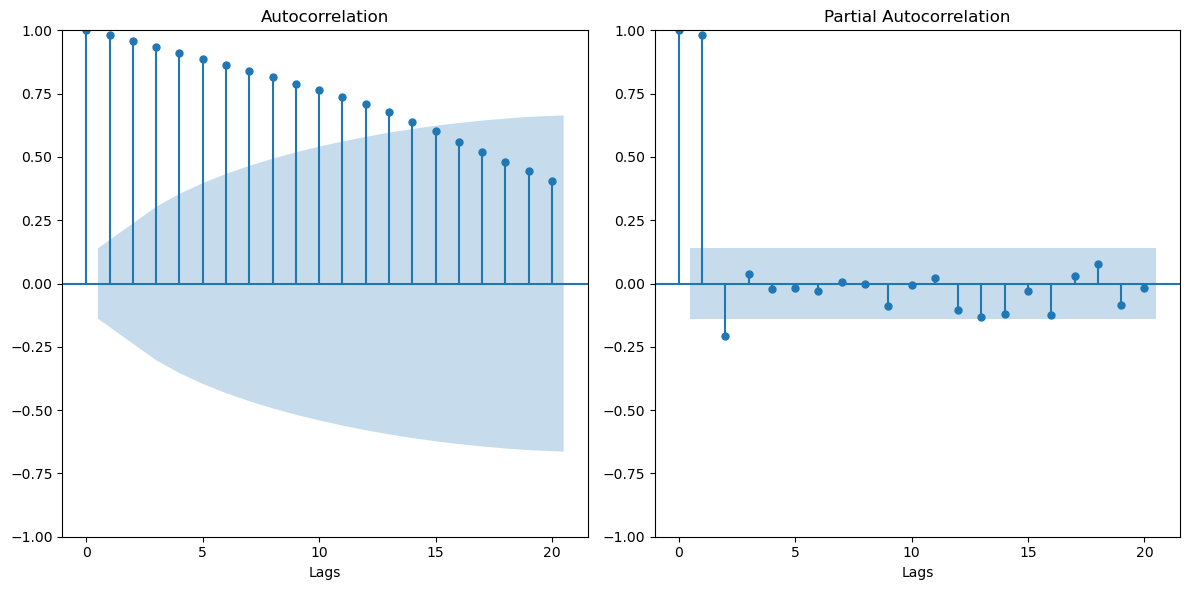

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(detrended_full, lags=20, ax=plt.gca())
plt.xlabel('Lags')
plt.subplot(122)
plot_pacf(detrended_full, lags=20, ax=plt.gca())
plt.tight_layout()
plt.xlabel('Lags')
plt.show()

We check the rolling mean and variance to check if our detrened time series is mean-reverting. If we have fluctuations in the mean and variance it means that our asset is not mean-reverting. In the next plot we can visualize how the variance had big fluctuation but our rolling mean is stable. This means that our asset is [heteroskedasticity](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) and we need to use a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to performe a forecasting in our dataset

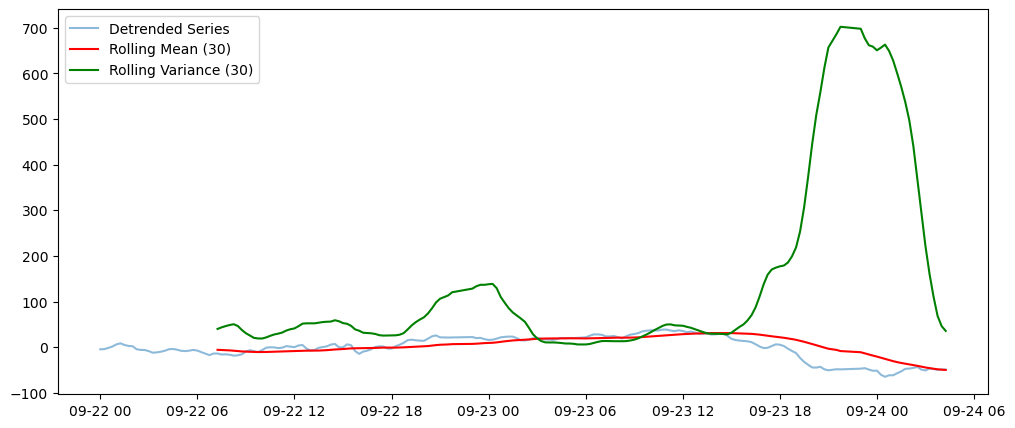

In [232]:
rolling_window = 30
rolling_mean = detrended_full.rolling(window=rolling_window).mean()
rolling_var = detrended_full.rolling(window=rolling_window).var()

plt.figure(figsize=(12, 5))
plt.plot(detrended_full, label='Detrended Series', alpha=0.5)
plt.plot(rolling_mean, label=f'Rolling Mean ({rolling_window})', color='red')
plt.plot(rolling_var, label=f'Rolling Variance ({rolling_window})', color='green')
plt.legend()
plt.show()

Because our mean is stable we can have an approach with an ARIMA (AutoRegressive Integrated Moving Average) model.ARIMA captures dependencies in the data by combining autoregressive (AR) terms, moving average (MA) terms, and differencing (I) to remove trends.

In the AutoRegressive model, current values depends on a linear combination of pthe past values. Is define as
$$y_t=C+\phi_1y_{t-1}+\phi_2y_{t-2}+...\phi_qy_{t-q}+\varepsilon t$$
Where $\varepsilon$ is white noise, $y_t$ is the current value, $\phi_t$ are the AR coefficient and $p$ is the AR order (number of lag terms)

Instead, the moving average use the past forecasting errors (residuals) giving us a smoothed fluctuations
$$y_t=C+\varepsilon t+\theta_1\varepsilon t_1+\theta_2\varepsilon t_2+...\theta_q\varepsilon t_q$$
Where $\varepsilon$ is white noise, $\theta_t$ are the MA coefficient and $q$ number of past error values

The last component is the differencing (I) this is used if our data is non-stationaty and make it stationary

In [233]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(detrended_full, seasonal=False, trace=True)
p, d, q = auto_arima_model.order  # Optimization of hyperparameters

arima_model = ARIMA(detrended_full, order=(p, d, q))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=971.558, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1037.693, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=998.619, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=968.823, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1036.631, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=970.811, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=970.808, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=972.135, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=967.338, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=969.332, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=969.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=996.989, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=970.620, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.183 seconds
                               SA

To determined if our data can be use in this model use the function plot_diagnostics of pmdarima library. Here we observe how our data behaves:

 -From the standardized residual we see the evolution of the residual over time, we dont see patterns meaning that the ARIMA model captured the trend.

 -In the histogram the residual behaves with a normal distribution, this is what we are searchin becuse an autoregerssive model cames form the integration of an  Ornstein Uhlenbeck process (which behaves with a normal distribution).

 -In the quantile-quntile plot we can see how the residual follows a normal distribution (red line)  

 -The correlogram we see how the correlation with lagas between the residual are inside of the confidence interval meaning that it can be considered as a white noise.

 Since residuals exhibit white noise behavior, our ARIMA model is well-fitted, making it a suitable choice for time series forecasting

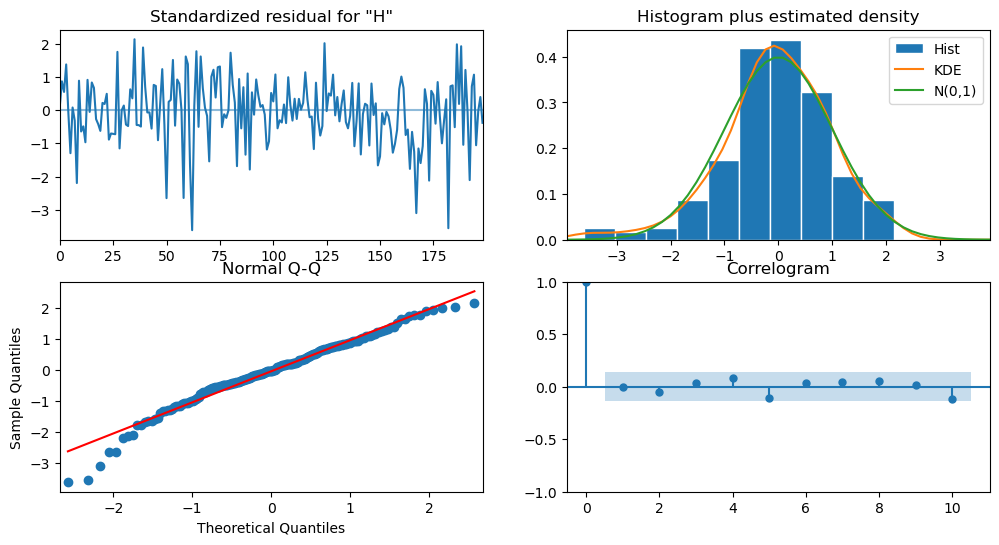

In [234]:
arima_model_fit.plot_diagnostics(figsize=(12, 6))
plt.show()

To forecast the fluctuation in the variance we use the [GARCH](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.GARCH.html#arch.univariate.GARCH) (Generalized AutoRegressive Conditional Heteroskedasticity) model. This model assume that the variances depend on the square error of the past and the past variance. Is define as

$$y=\mu+\varepsilon_t$$

With

$$\varepsilon_t=\sigma_t z_t,  \:\:\:\:    z_t∼ N(0,1)$$

$$\sigma_t = \omega + \alpha_1\varepsilon^2_{t-1} + \beta_1\sigma^2_{t-1}$$

Where $ω$ is the base variance level, $α_1$ is the measure of how new events increase the volatility and $β$ is the persistence of the past volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5741.465818041618
Iteration:      2,   Func. Count:     12,   Neg. LLF: 819.9368489807923
Iteration:      3,   Func. Count:     17,   Neg. LLF: 819.3203335252356
Iteration:      4,   Func. Count:     22,   Neg. LLF: 818.805838099915
Iteration:      5,   Func. Count:     27,   Neg. LLF: 818.7919249556468
Iteration:      6,   Func. Count:     33,   Neg. LLF: 818.6654960214794
Iteration:      7,   Func. Count:     38,   Neg. LLF: 818.6607623447113
Iteration:      8,   Func. Count:     43,   Neg. LLF: 818.660536033551
Iteration:      9,   Func. Count:     48,   Neg. LLF: 818.6605347158824
Iteration:     10,   Func. Count:     52,   Neg. LLF: 818.6605349459694
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               HA_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-L

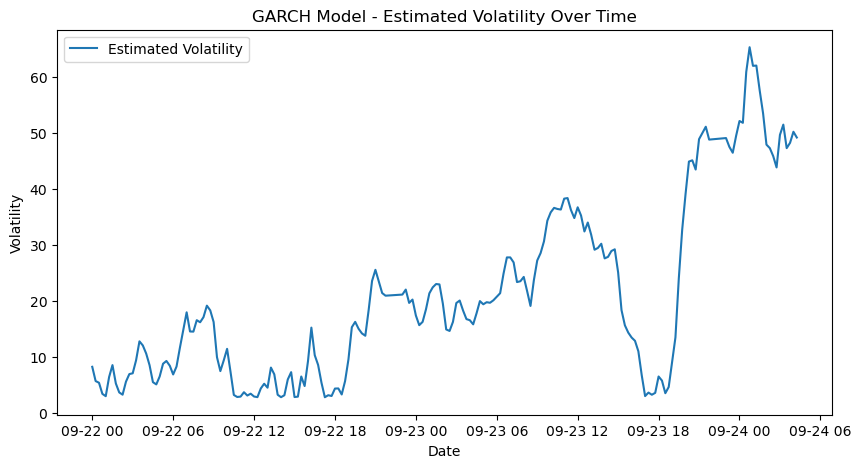

In [235]:
from arch import arch_model

returns = detrended_full

# Fit GARCH(1,1)
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="on")

# Print summary
print(garch_fit.summary())

plt.figure(figsize=(10,5))
plt.plot(garch_fit.conditional_volatility, label="Estimated Volatility")
plt.title("GARCH Model - Estimated Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

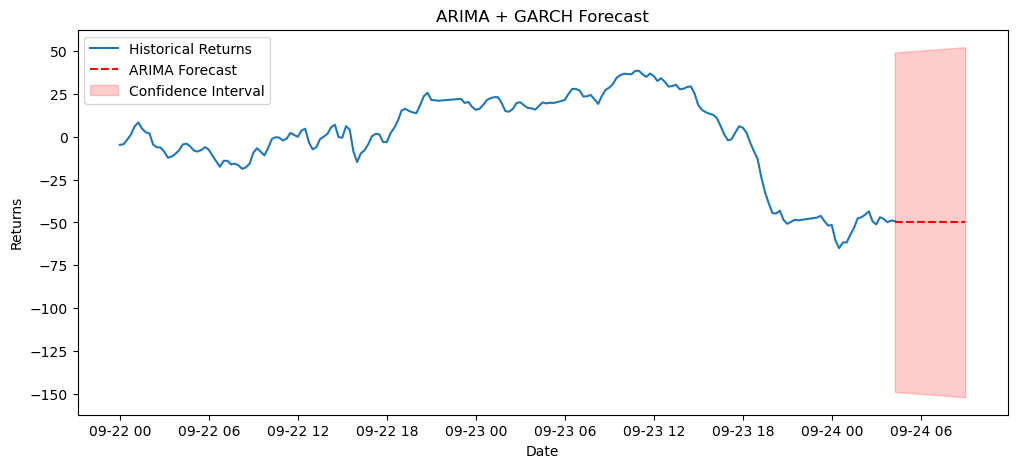

In [236]:
arima_forecast = arima_model_fit.get_forecast(steps=20)

# Forecast volatility using GARCH
garch_forecast = garch_fit.forecast(horizon=20)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# New range
future_dates = pd.date_range(detrended_full.index[-1] , periods=20, freq="15T")


plt.figure(figsize=(12,5))
plt.plot(detrended_full, label="Historical Returns")
plt.plot(future_dates, arima_forecast.predicted_mean, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.fill_between(future_dates,
                 arima_forecast.predicted_mean - 2 * volatility_forecast,
                 arima_forecast.predicted_mean + 2 * volatility_forecast,
                 color="red", alpha=0.2, label="Confidence Interval")
plt.title("ARIMA + GARCH Forecast")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

Our first approach in the forecaste is really poor becuase it lost a lot of information and cannot capture patterns. This make difficult to predict future values. A solution is consider the SARIMA (Seasonal AutoRegressive Integrated Moving Average) model, which add a seasonal component in the ARIMA model. For this we need 3 new hyperpatameter that definal the seasonal behavior of our time series.

The equation is: 

$$\Phi_P(B^s) \phi_p(B) (1 - B)^d (1 - B^s)^D Y_t = \Theta_Q(B^s) \theta_q(B) \epsilon_t$$

Where

  $\Phi_P(B^s)$ :  Seasonal autoregressive polynomial 
  
  $\Theta_Q(B^s)$ : Seasonal moving average polynomial
  
  B : Backward Shift Operator $B^kY_t = Y_{t-k}$   

  P : Number of seasonal autoregressive terms.

  D : Number of seasonal differences applied to remove seasonal trends.

  Q : Number of seasonal moving average terms.

These parameters define how the model captures seasonal dependencies, improving its ability to forecast time series with periodic patterns.

We use a grid search algorithm to optimize the hyperparameter

In [237]:
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


serie = detrended_full

train = serie[:180]
test = serie[180:]

# Define the parameter ranges
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = [15]  # Data is taken every 15 min.

best_aic = float("inf")
best_params = None

for param in itertools.product(p, d, q):
    for seasonal_param in itertools.product(P, D, Q, s):
        try:
            model = sm.tsa.statespace.SARIMAX(
                train,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=0)  # Suppress output
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f"Best SARIMAX order: {best_params[0]}, Best Seasonal Order: {best_params[1]}")

Best SARIMAX order: (2, 1, 2), Best Seasonal Order: (0, 1, 1, 15)


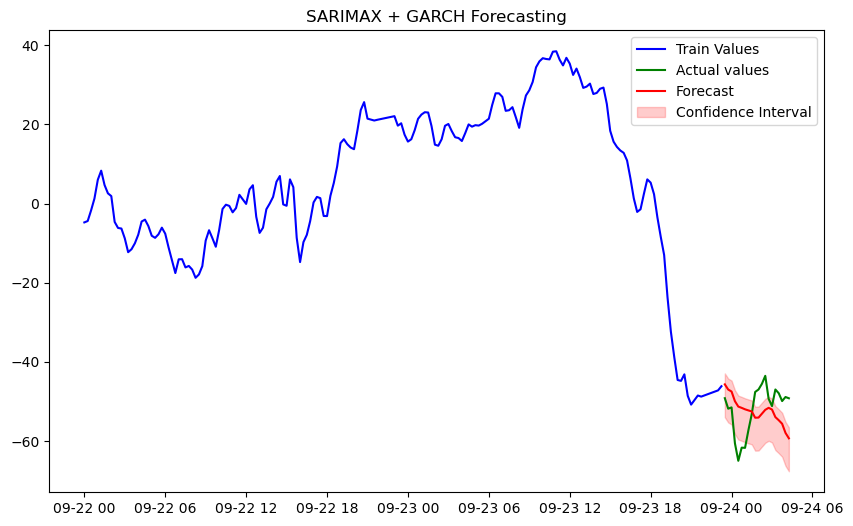

In [238]:
import arch

# Forcast steps
horizon =20

# Sarimax model
sarimax_model = sm.tsa.statespace.SARIMAX(train, order=best_params[0], seasonal_order=best_params[1])
sarimax_fitted = sarimax_model.fit(disp=False)

# Residuals
sarimax_residuals = sarimax_fitted.resid

garch = arch.arch_model(sarimax_residuals, vol='Garch', p=1, q=2)
garch_fitted = garch.fit(disp="off")

# Forecast mean with SARIMAX
predicted_mu = sarimax_fitted.predict(start=len(train), end=len(train) + horizon - 1, dynamic=False).values

# Forecast volatility using GARCH model
garch_forecast = garch_fitted.forecast(horizon=horizon)
predicted_et = np.sqrt(garch_forecast.variance.values[-1,:])


predictions = predicted_mu + predicted_et


forecast_dates = pd.date_range(start=test.index[0], periods=horizon, freq="15T")
forecast_df = pd.DataFrame({'Forecast': predictions}, index=forecast_dates)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label="Train Values", color="blue")
plt.plot(test.index, test.values, label="Actual values", color="green")
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast", color="red")
plt.fill_between(forecast_df.index,
                 predicted_mu - 2 * predicted_et,
                 predicted_mu + 2 * predicted_et,
                 color="red", alpha=0.2, label="Confidence Interval")

plt.title('SARIMAX + GARCH Forecasting')
plt.legend()
plt.show()


In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test = test
mae = mean_absolute_error(y_test, forecast_df['Forecast'].values)
rmse = np.sqrt(mean_squared_error(y_test, forecast_df['Forecast'].values))
mape = np.mean(np.abs((y_test - forecast_df['Forecast'].values) / y_test)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

MAE: 6.686105954825669, RMSE: 7.470020823575571, MAPE: 12.799059976130046%


## Future work

-Try other forecasting method, for example Machine Learning algorithms (LSTM, XGBoost) and compare the results

-With a better forecasting is possible to apply a tradeoff strategy